In [1]:
import re
import toml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
from toolz import compose

In [2]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/param_scan')

In [3]:
models = sorted(folder.glob('**/*.ckpt'))

In [4]:
models[:3]

[PosixPath('/n/groups/datta/win/longtogeny/size_norm/models/param_scan/01ab0371-0b0f-413e-b9eb-e2a7ec449876/UNet-epoch=80-val_loss=7.19e-04.ckpt'),
 PosixPath('/n/groups/datta/win/longtogeny/size_norm/models/param_scan/022c07f9-d943-4fbd-8e0a-b33633017a1b/Autoencoder-epoch=56-val_loss=5.04e-03.ckpt'),
 PosixPath('/n/groups/datta/win/longtogeny/size_norm/models/param_scan/04786c54-08fd-47b6-928c-ab770f508c52/UNet-epoch=67-val_loss=5.34e-03.ckpt')]

In [5]:
pattern = re.compile(r'val_loss=(\d\.\d{2}e-\d{2})\.ckpt')

In [6]:
float(pattern.search(str(models[0])).group(1))

0.000719

In [7]:
get_loss = compose(float, lambda x: pattern.search(x).group(1), str)

In [8]:
losses = list(map(get_loss, models))

In [9]:
best, _ = min(zip(models, losses), key=lambda x: x[1])

In [10]:
best

PosixPath('/n/groups/datta/win/longtogeny/size_norm/models/param_scan/31a74eec-6d58-4059-a8d8-941fe5a76208/UNet-epoch=70-val_loss=5.23e-04.ckpt')

In [11]:
df = []
for model, loss in zip(tqdm(models), losses):
    config = toml.load(model.with_name('config.toml'))
    mdl_params = config['model']
    d = dict(
        path=str(model),
        mse=loss,
        depth=len(mdl_params['channels']),
        channels=mdl_params['channels'],
        arch=mdl_params['arch'],
        separable=mdl_params['separable'],
    )
    for i, c in enumerate(mdl_params['channels']):
        d[f'ch_{i}'] = c
    df.append(d)
df = pd.DataFrame(df)

  0%|          | 0/185 [00:00<?, ?it/s]

[(0.0, 0.007496214949511026)]

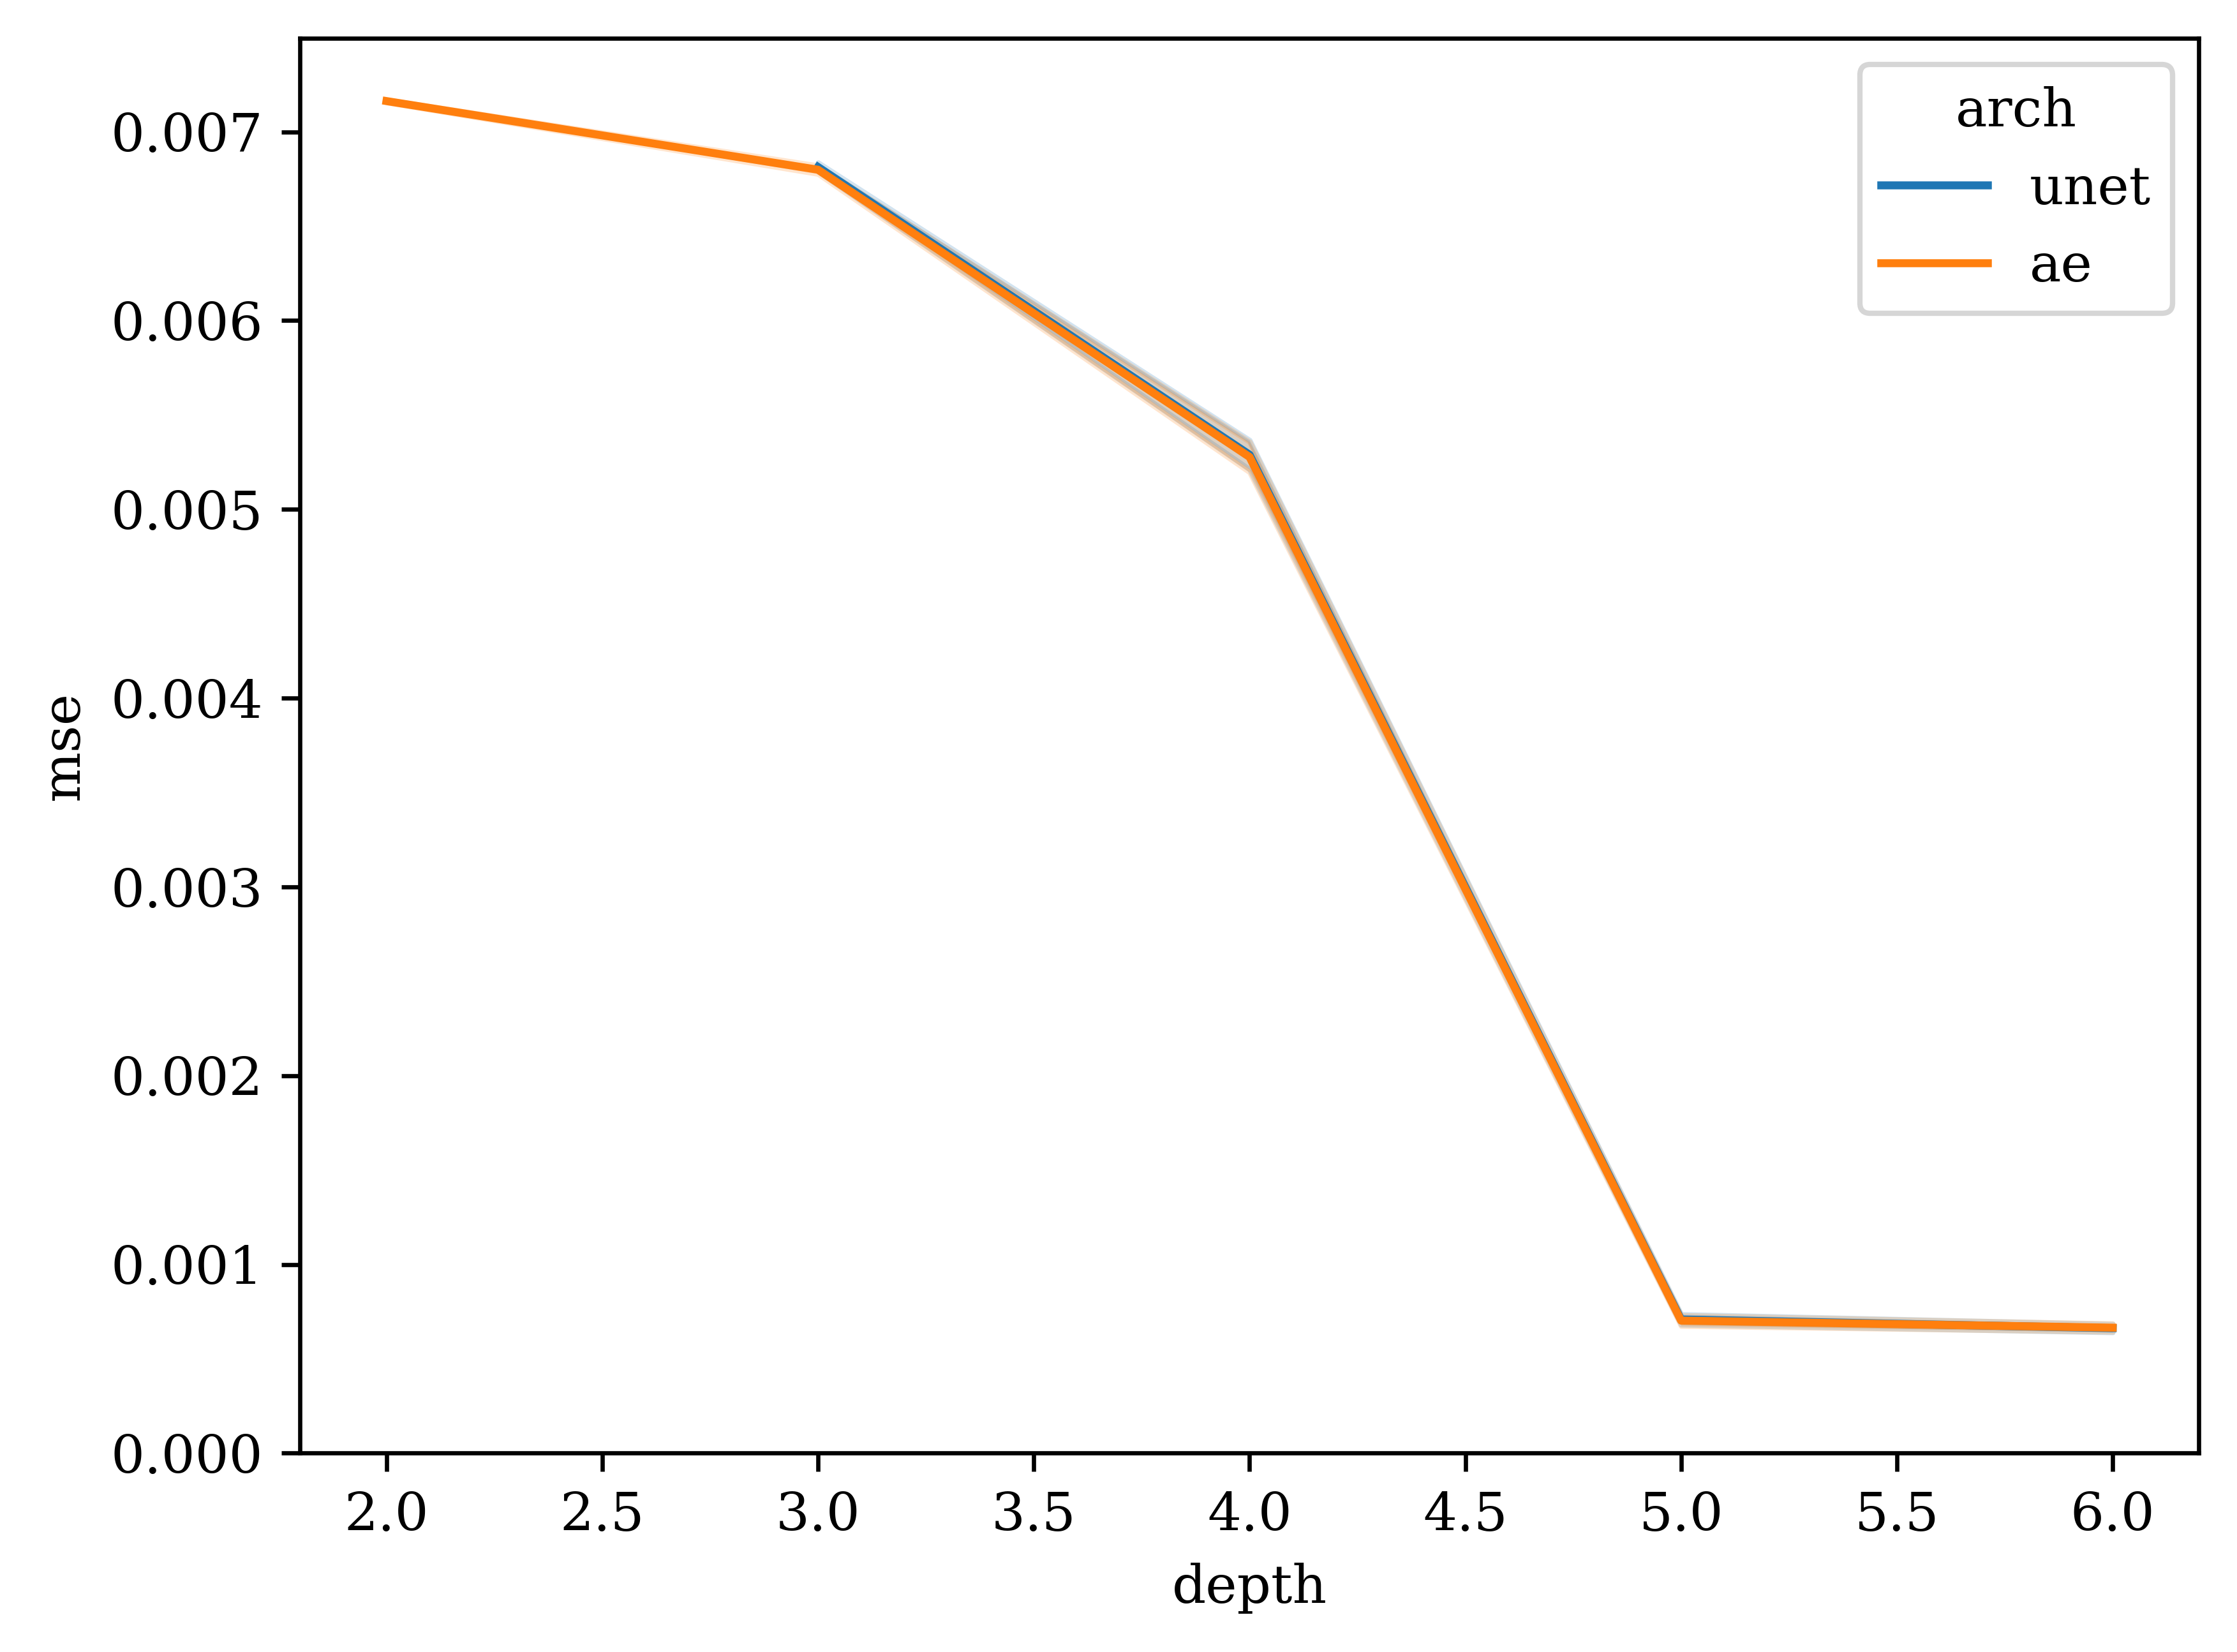

In [12]:
ax = sns.lineplot(data=df, x='depth', y='mse', hue='arch', errorbar='se')
ax.set(ylim=(0, None))

[(0.0, 0.00746035)]

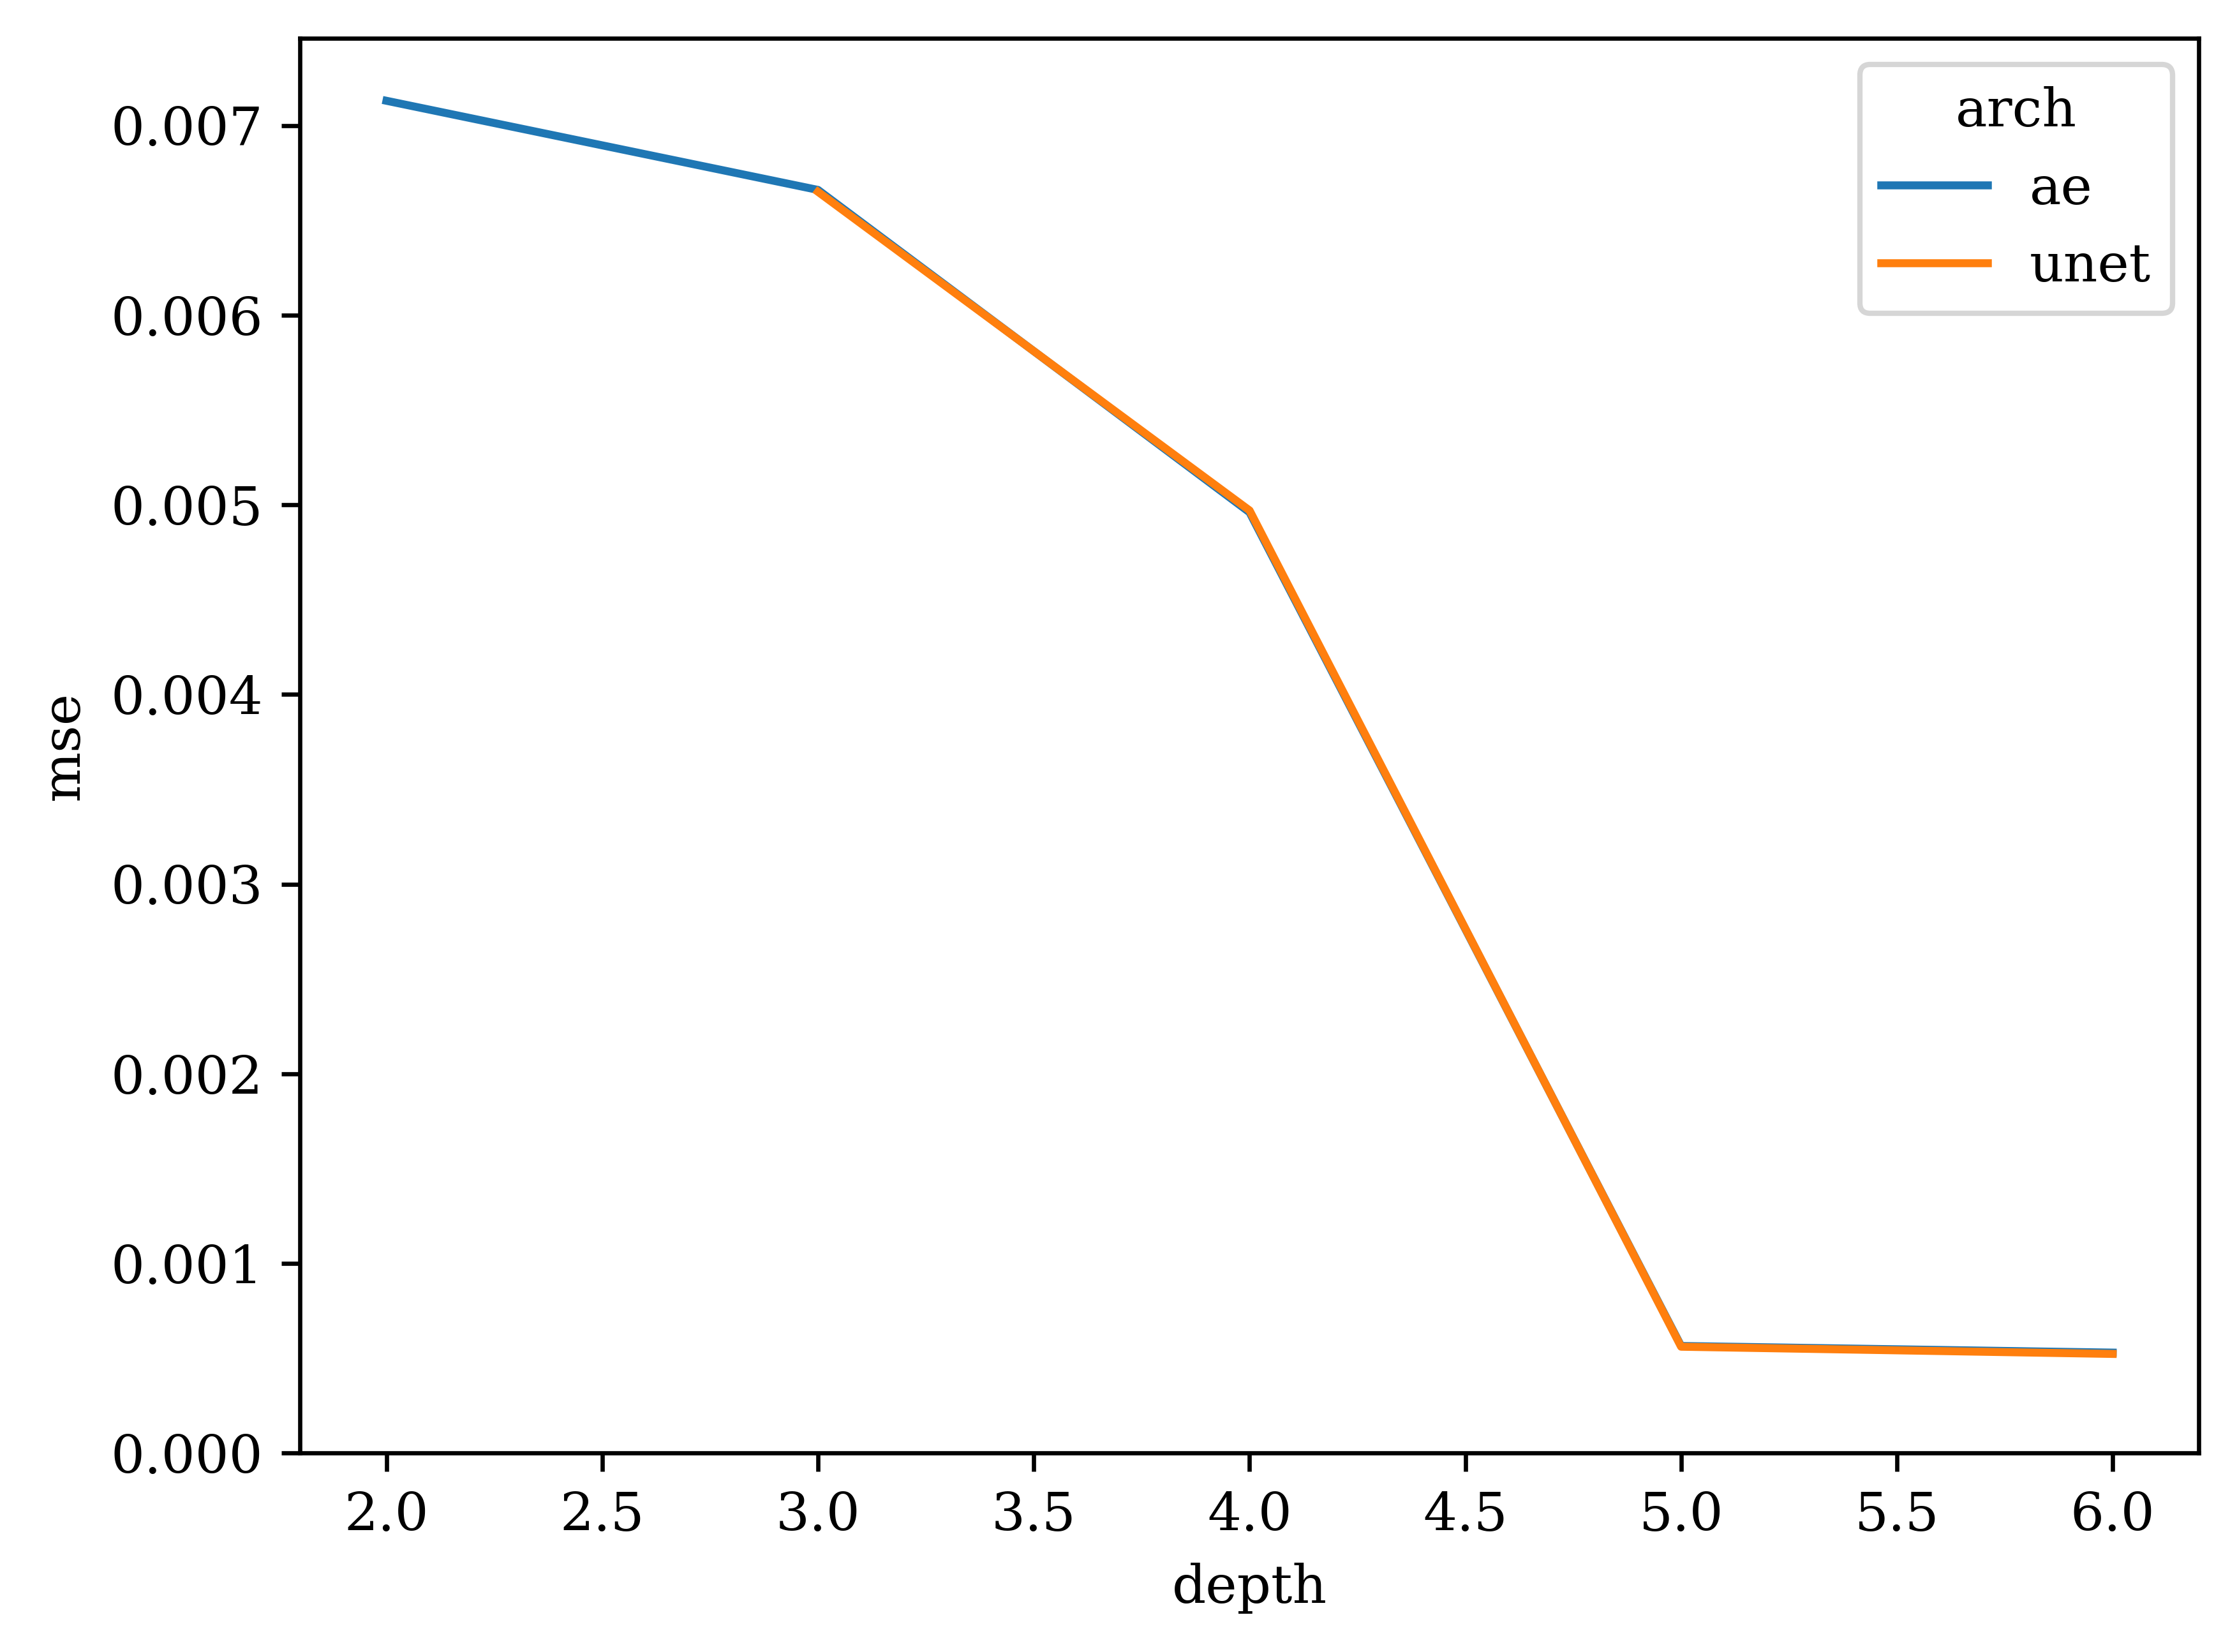

In [13]:
ax = sns.lineplot(
    data=df.groupby(["depth", "arch"])["mse"].min().reset_index(),
    x="depth",
    y="mse",
    hue="arch",
)
ax.set(ylim=(0, None))

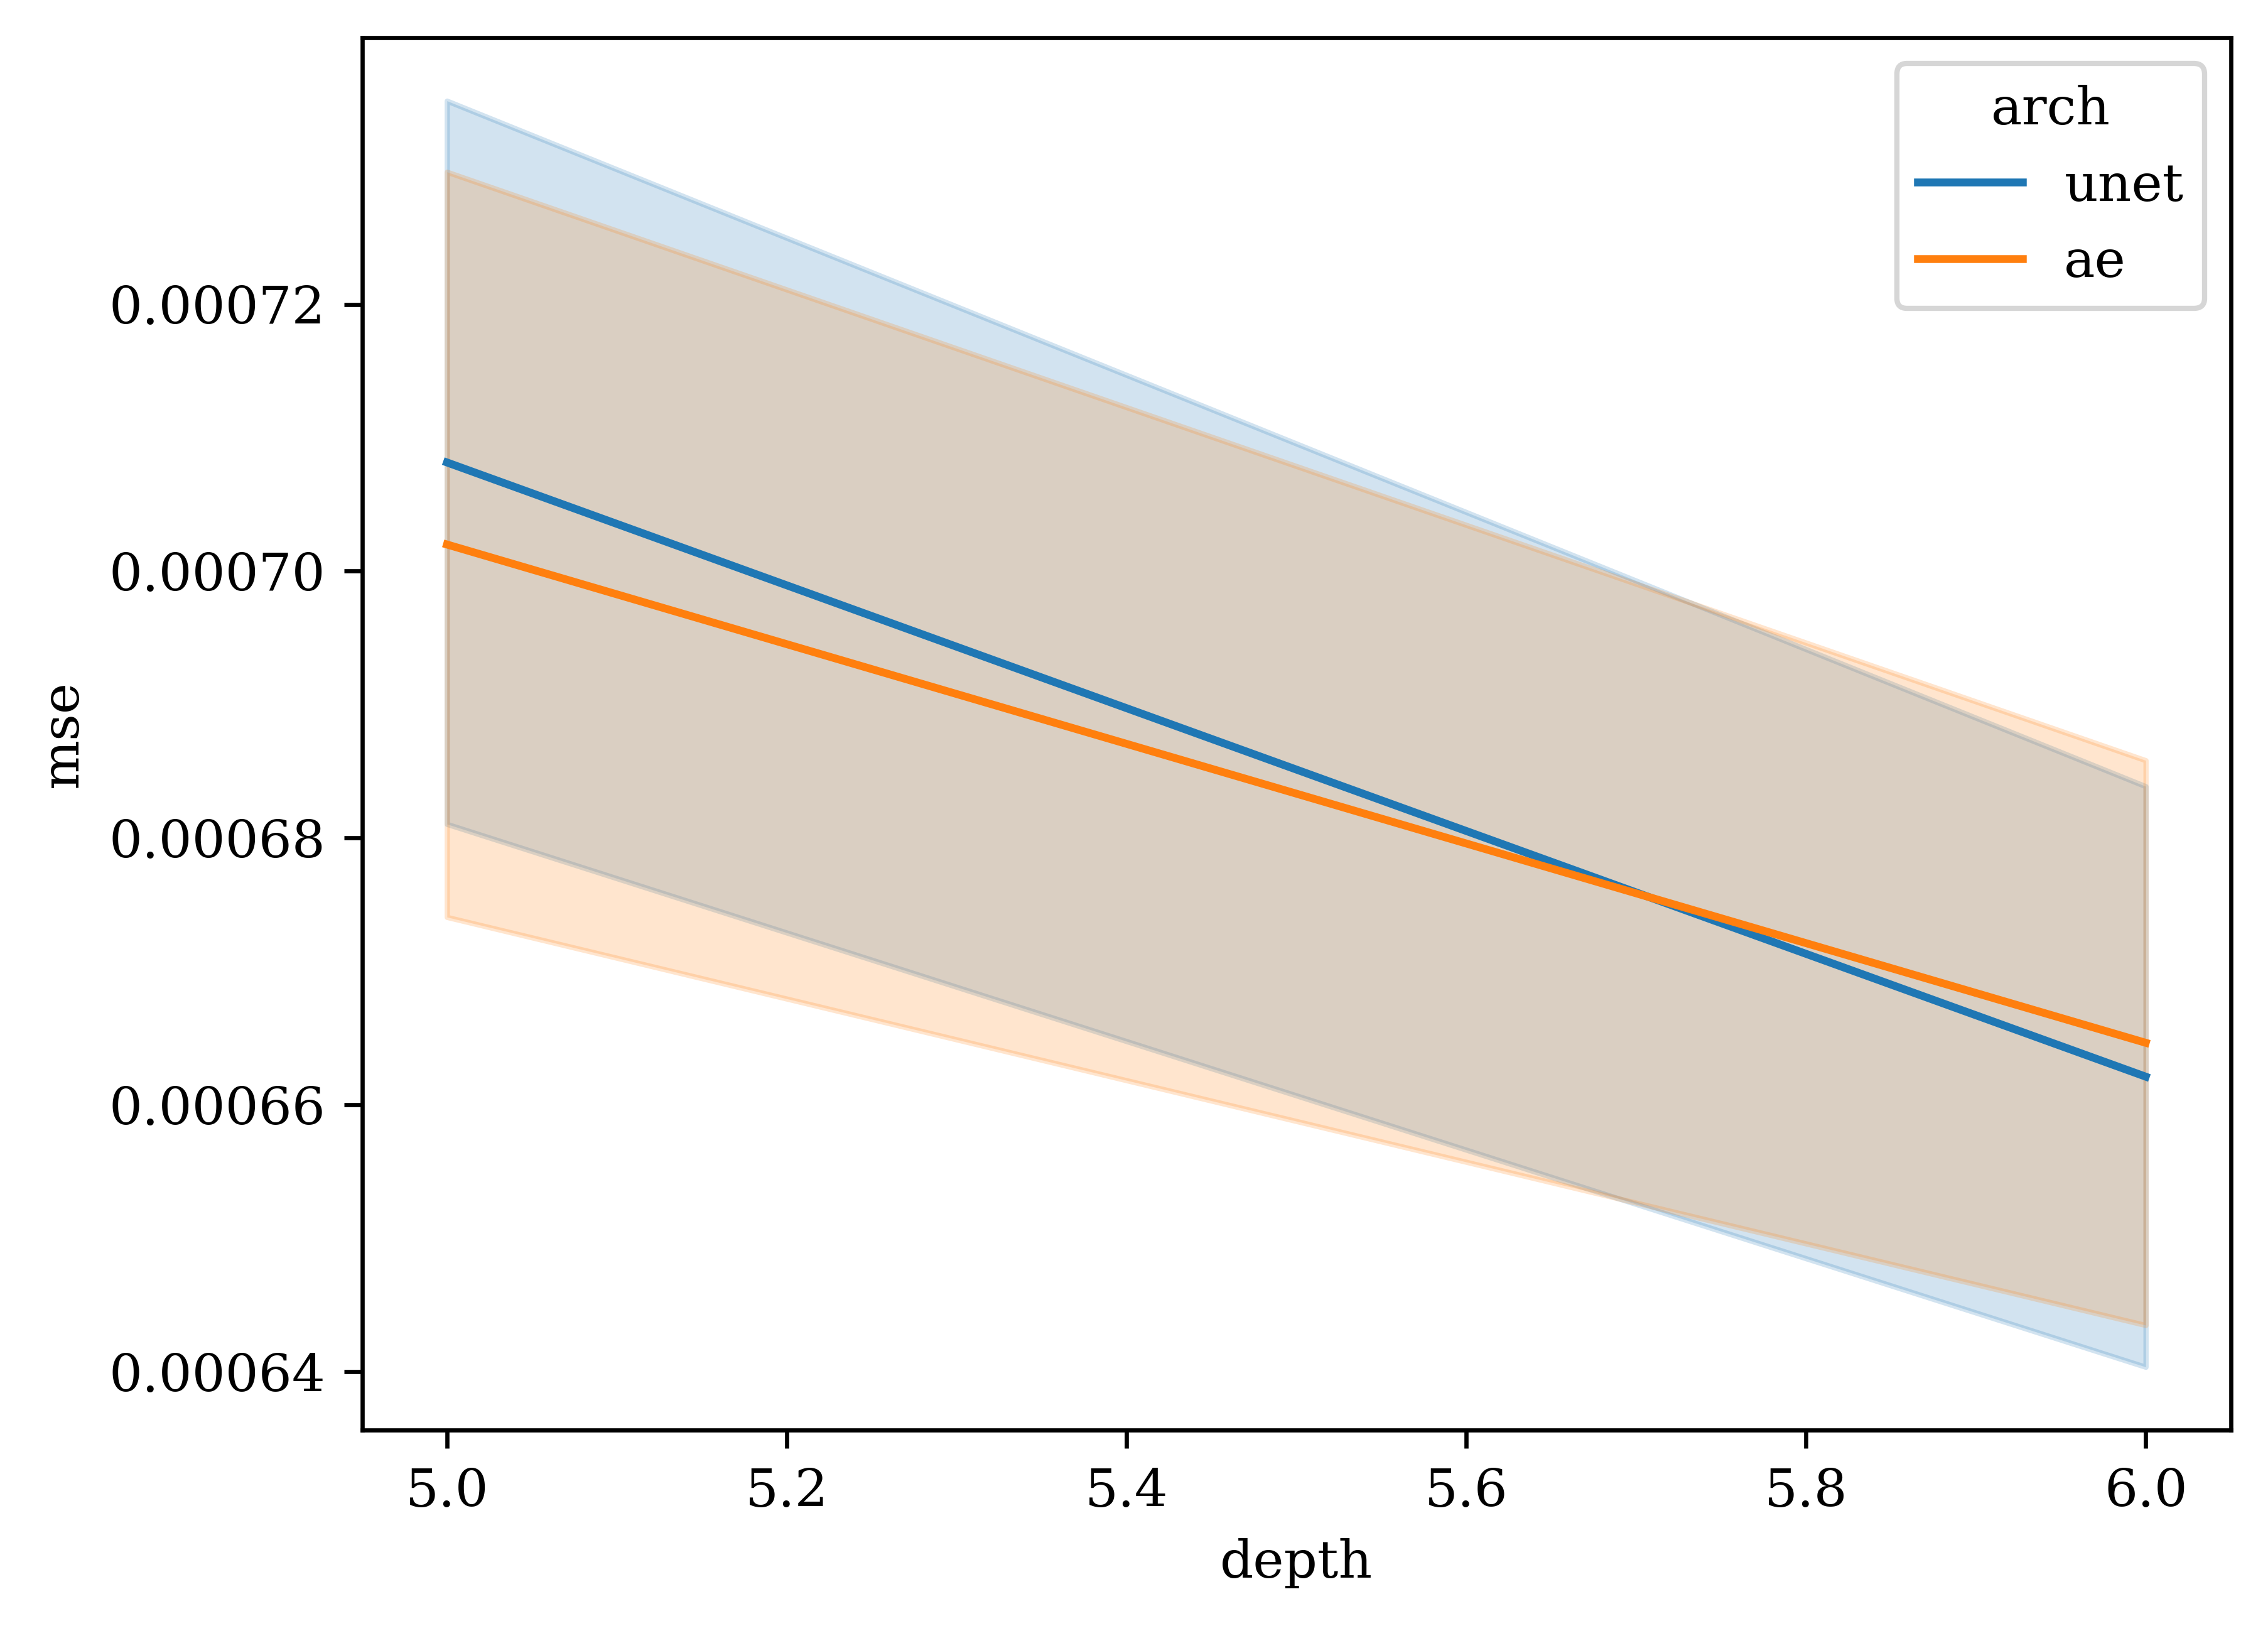

In [14]:
ax = sns.lineplot(data=df.query('depth > 4'), x='depth', y='mse', hue='arch', errorbar='se')
# ax.set(ylim=(0, None))

<Axes: xlabel='arch', ylabel='mse'>

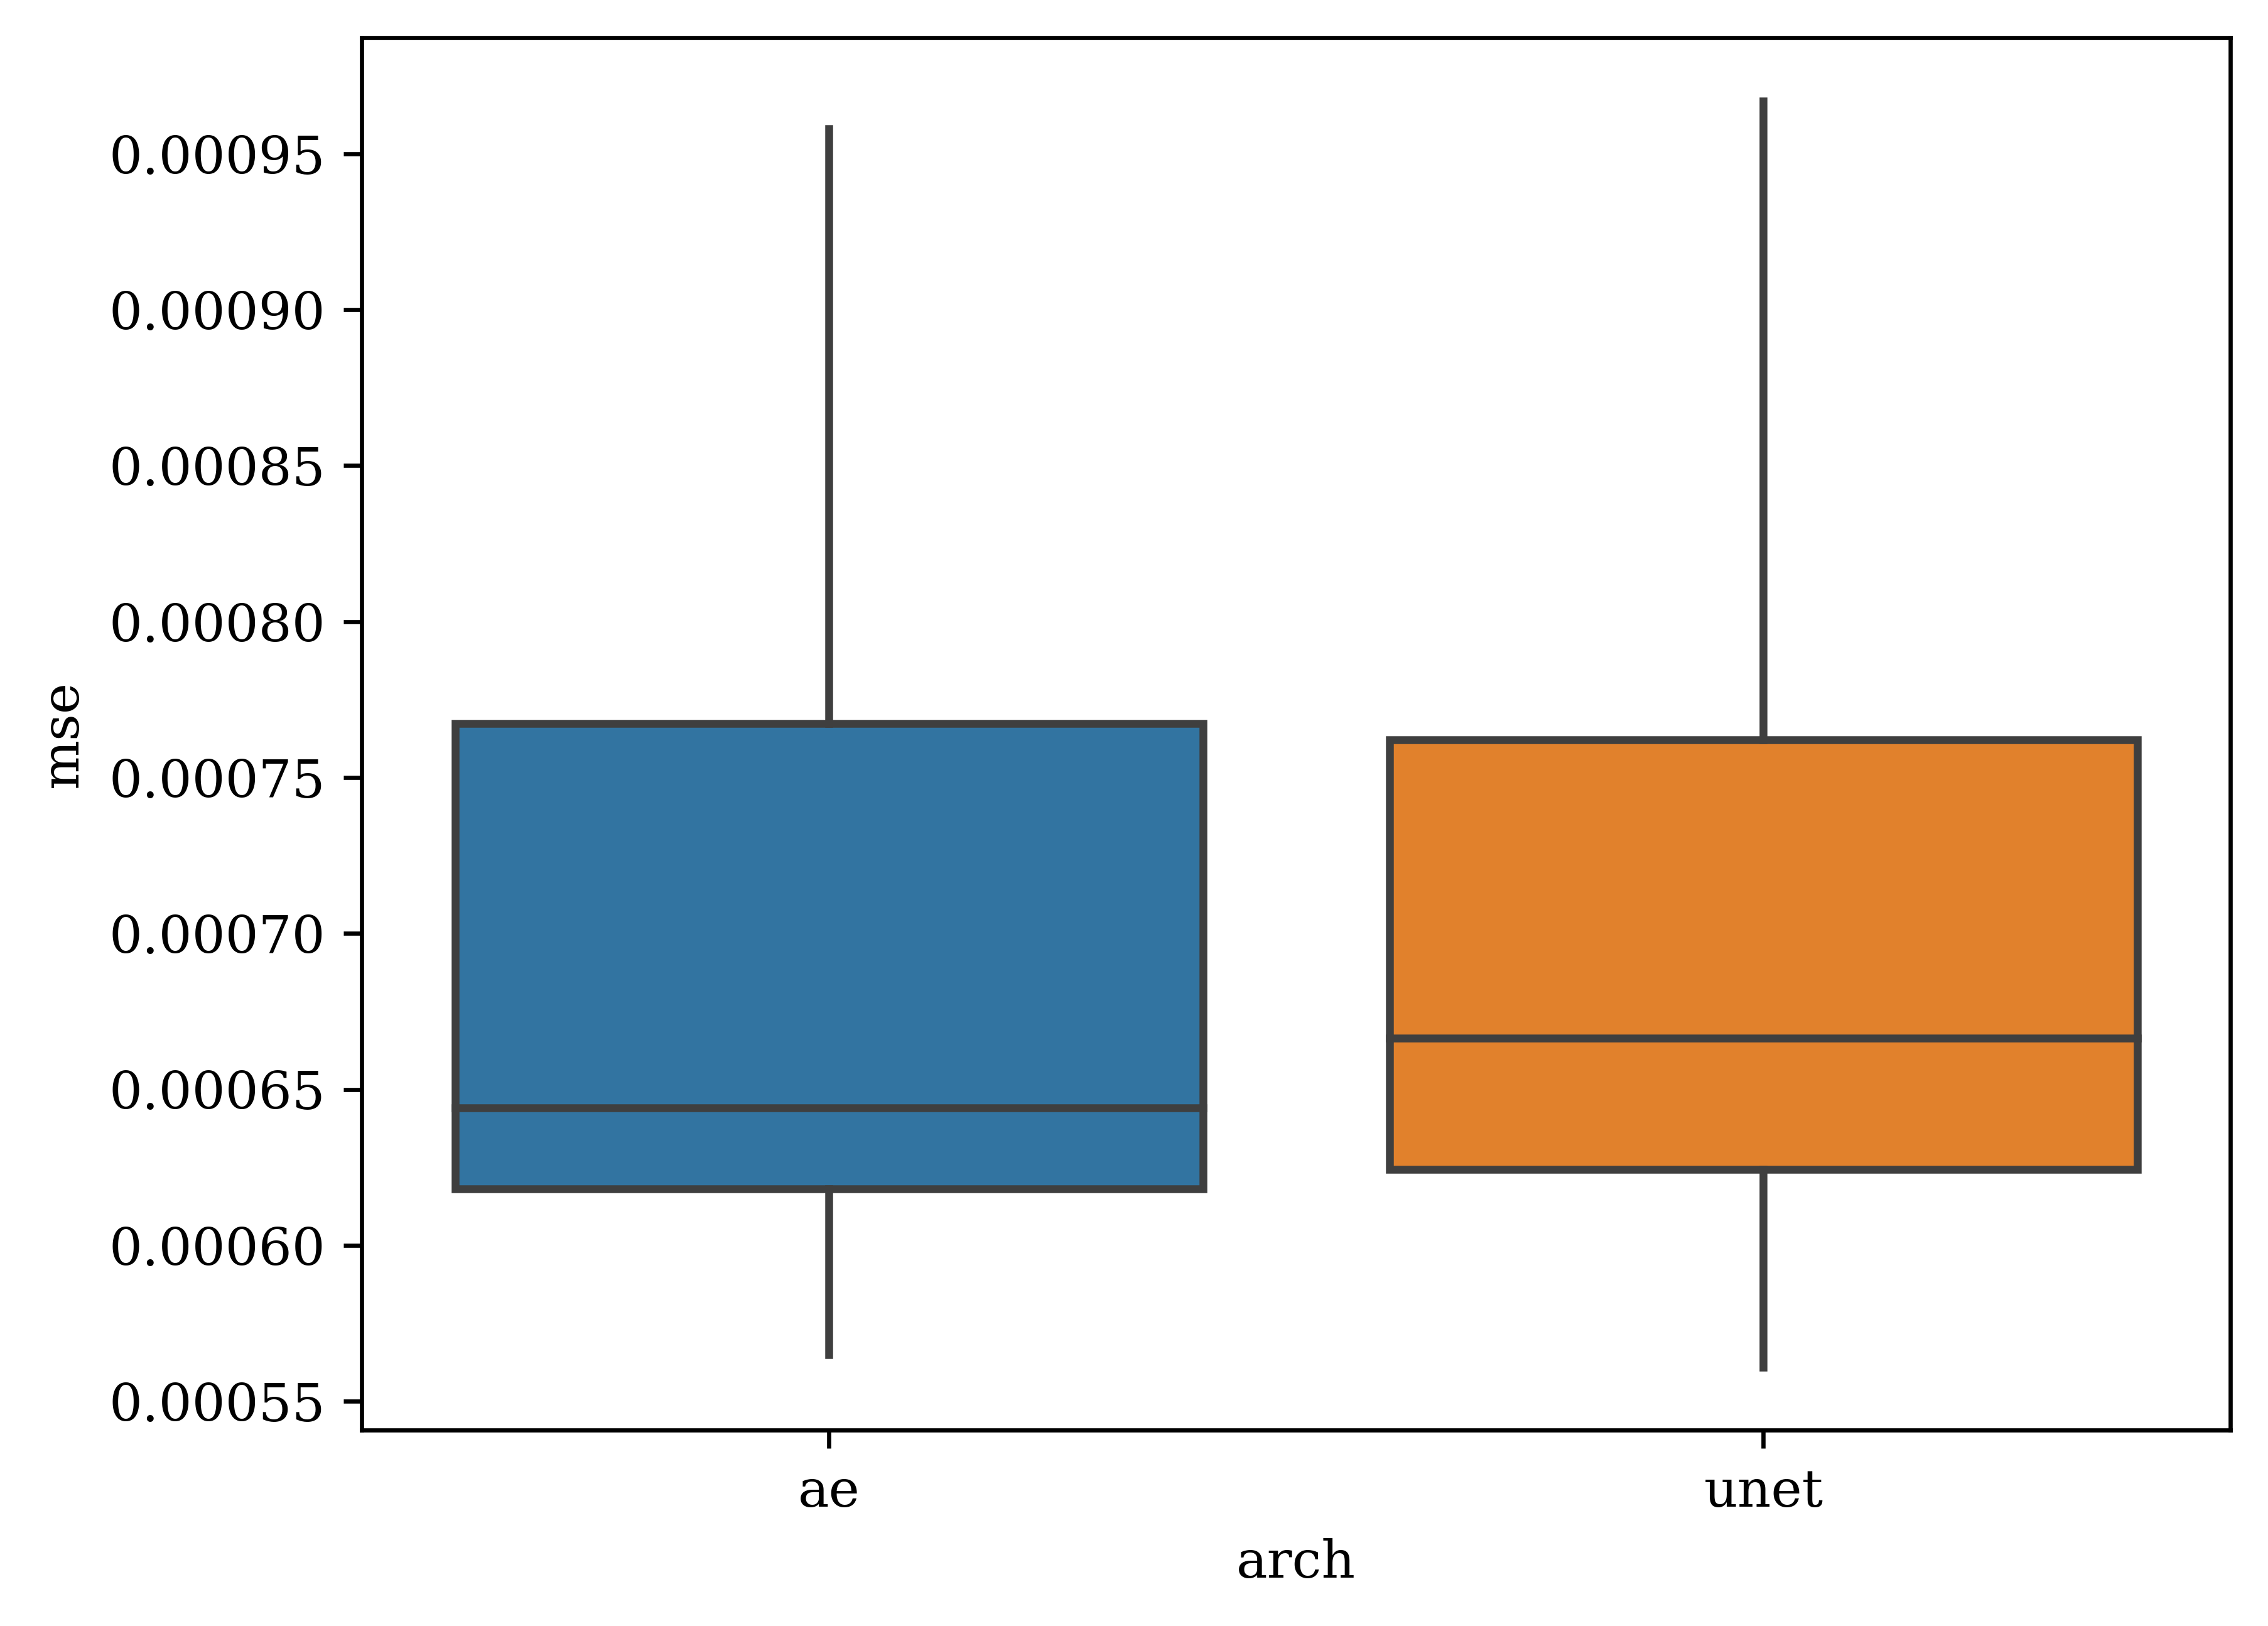

In [15]:
sns.boxplot(data=df.query('depth == 5'), x='arch', y='mse', showcaps=False)

<Axes: xlabel='arch', ylabel='mse'>

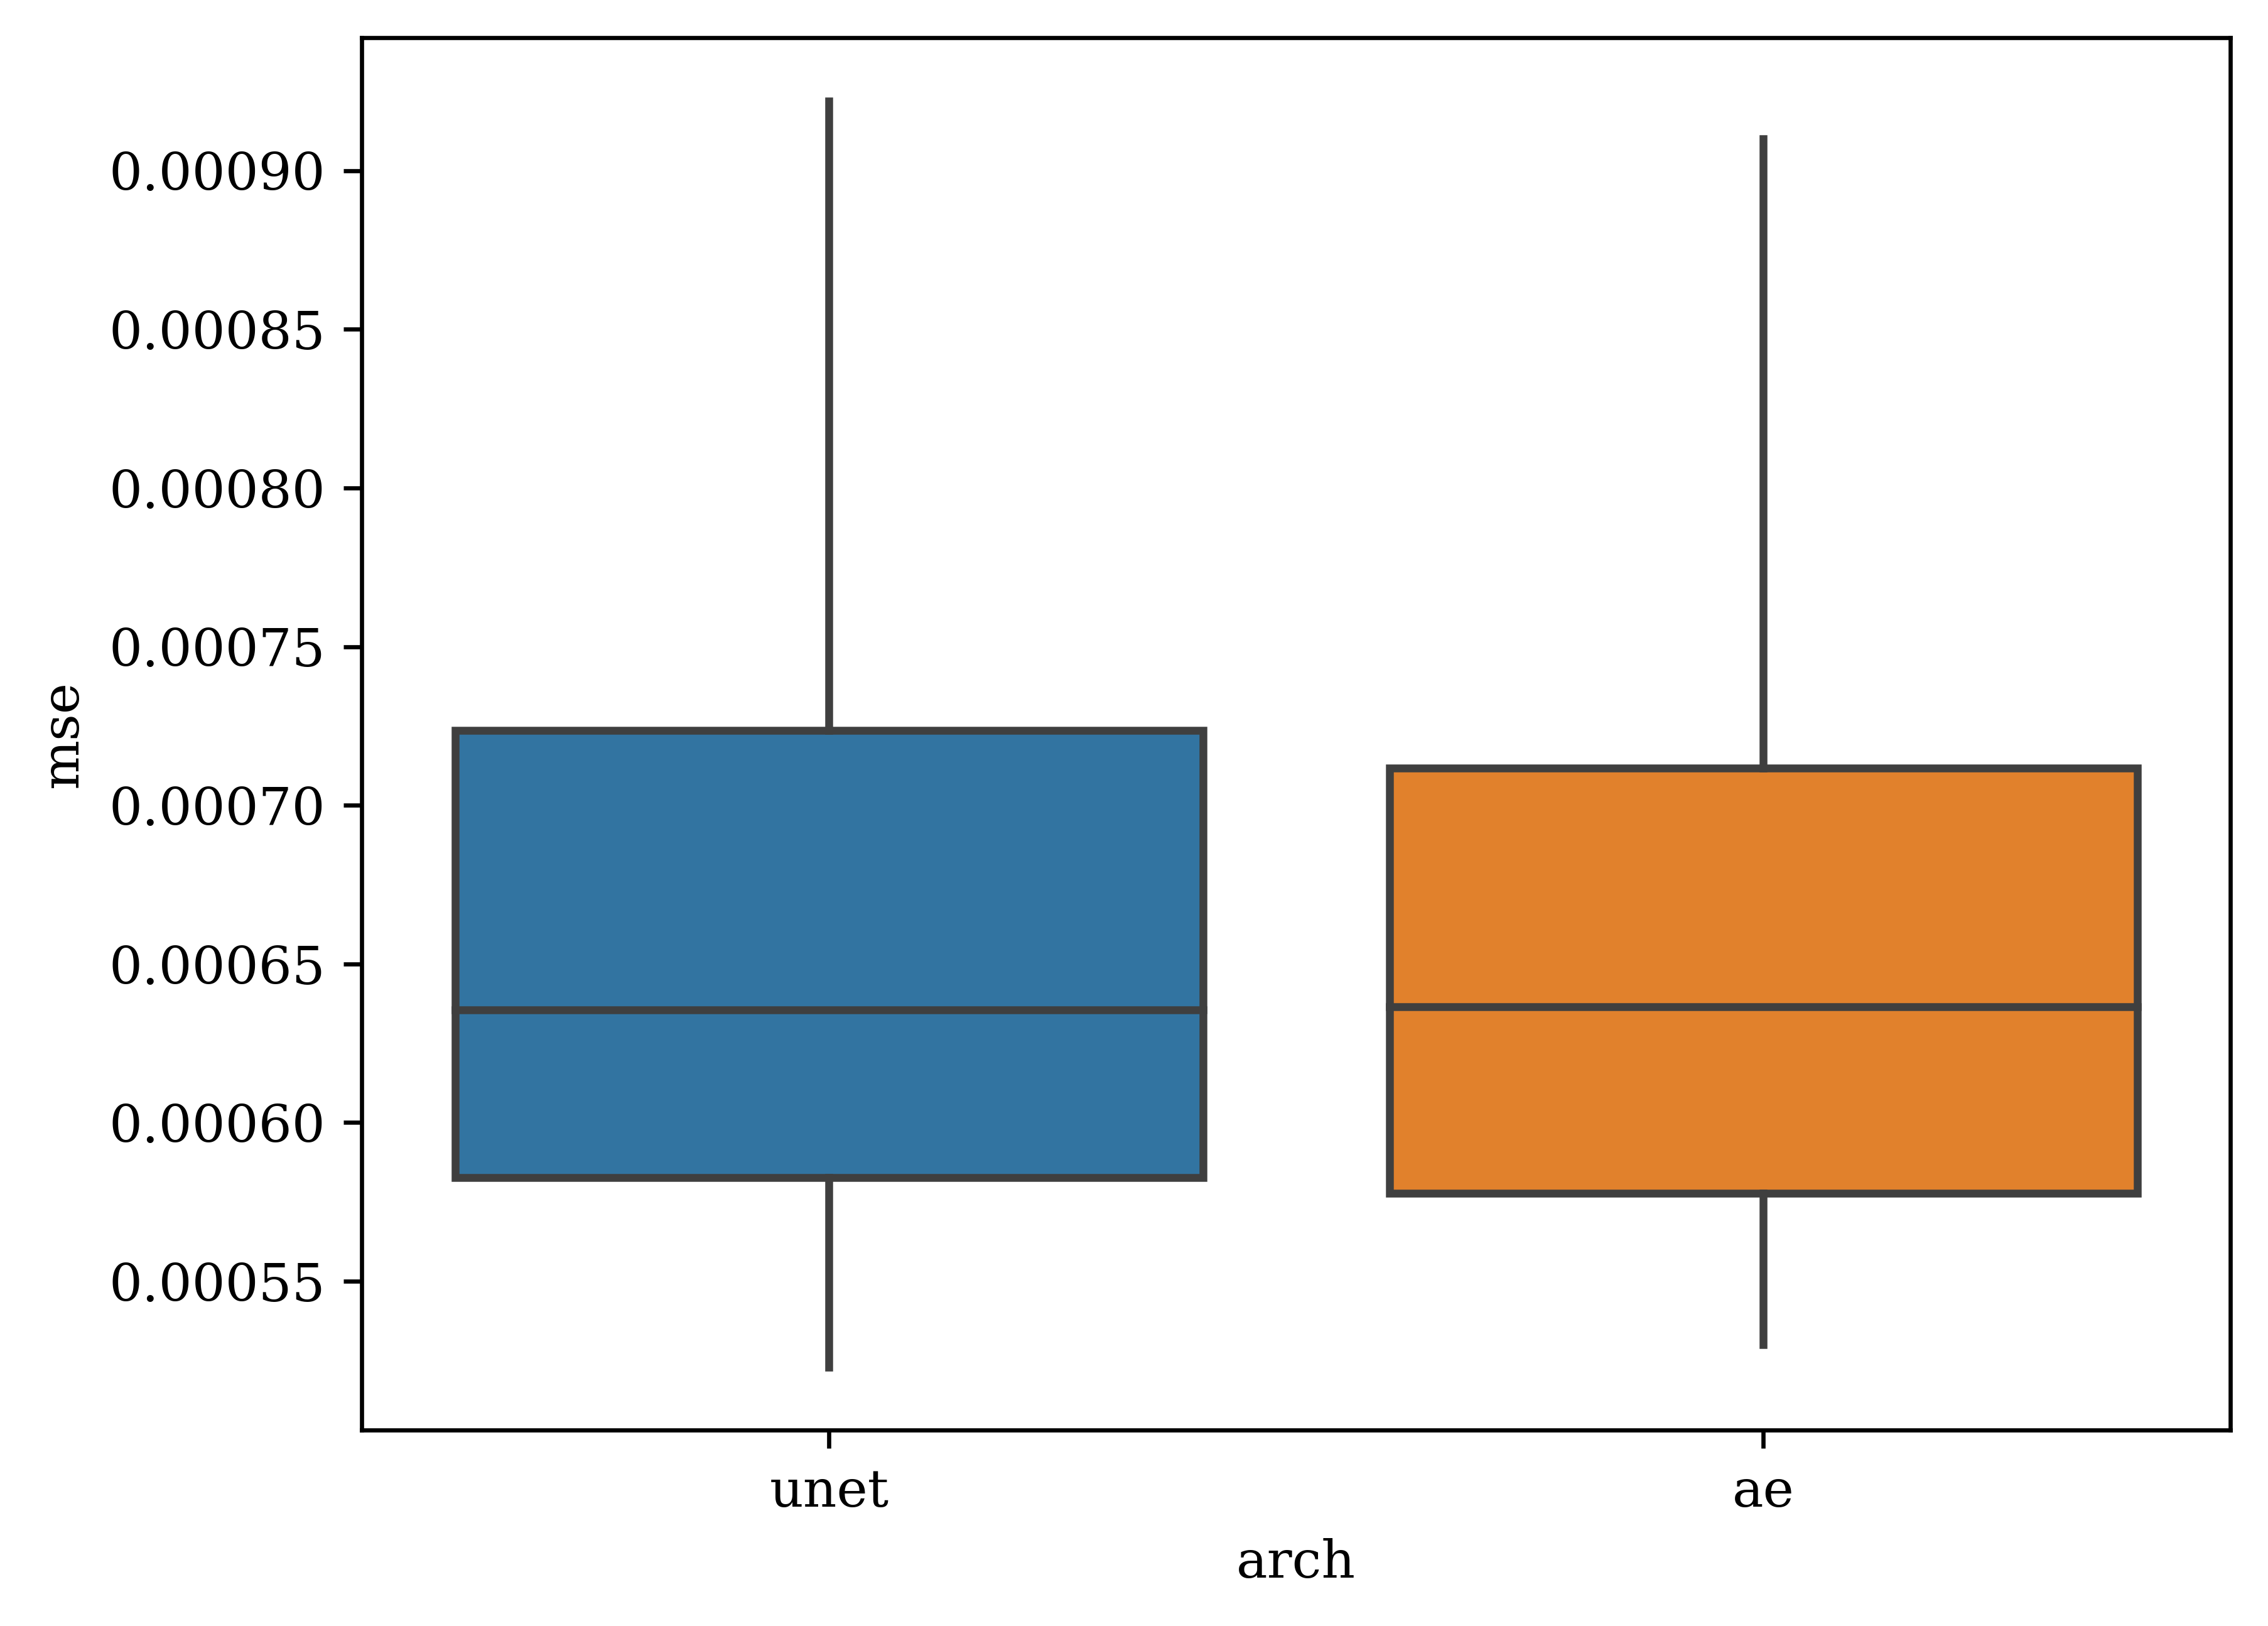

In [16]:
sns.boxplot(data=df.query('depth == 6'), x='arch', y='mse', showcaps=False)

In [17]:
sorted_depth_df = df.query('depth == 6').sort_values(by=[f'ch_{i}' for i in range(5)])

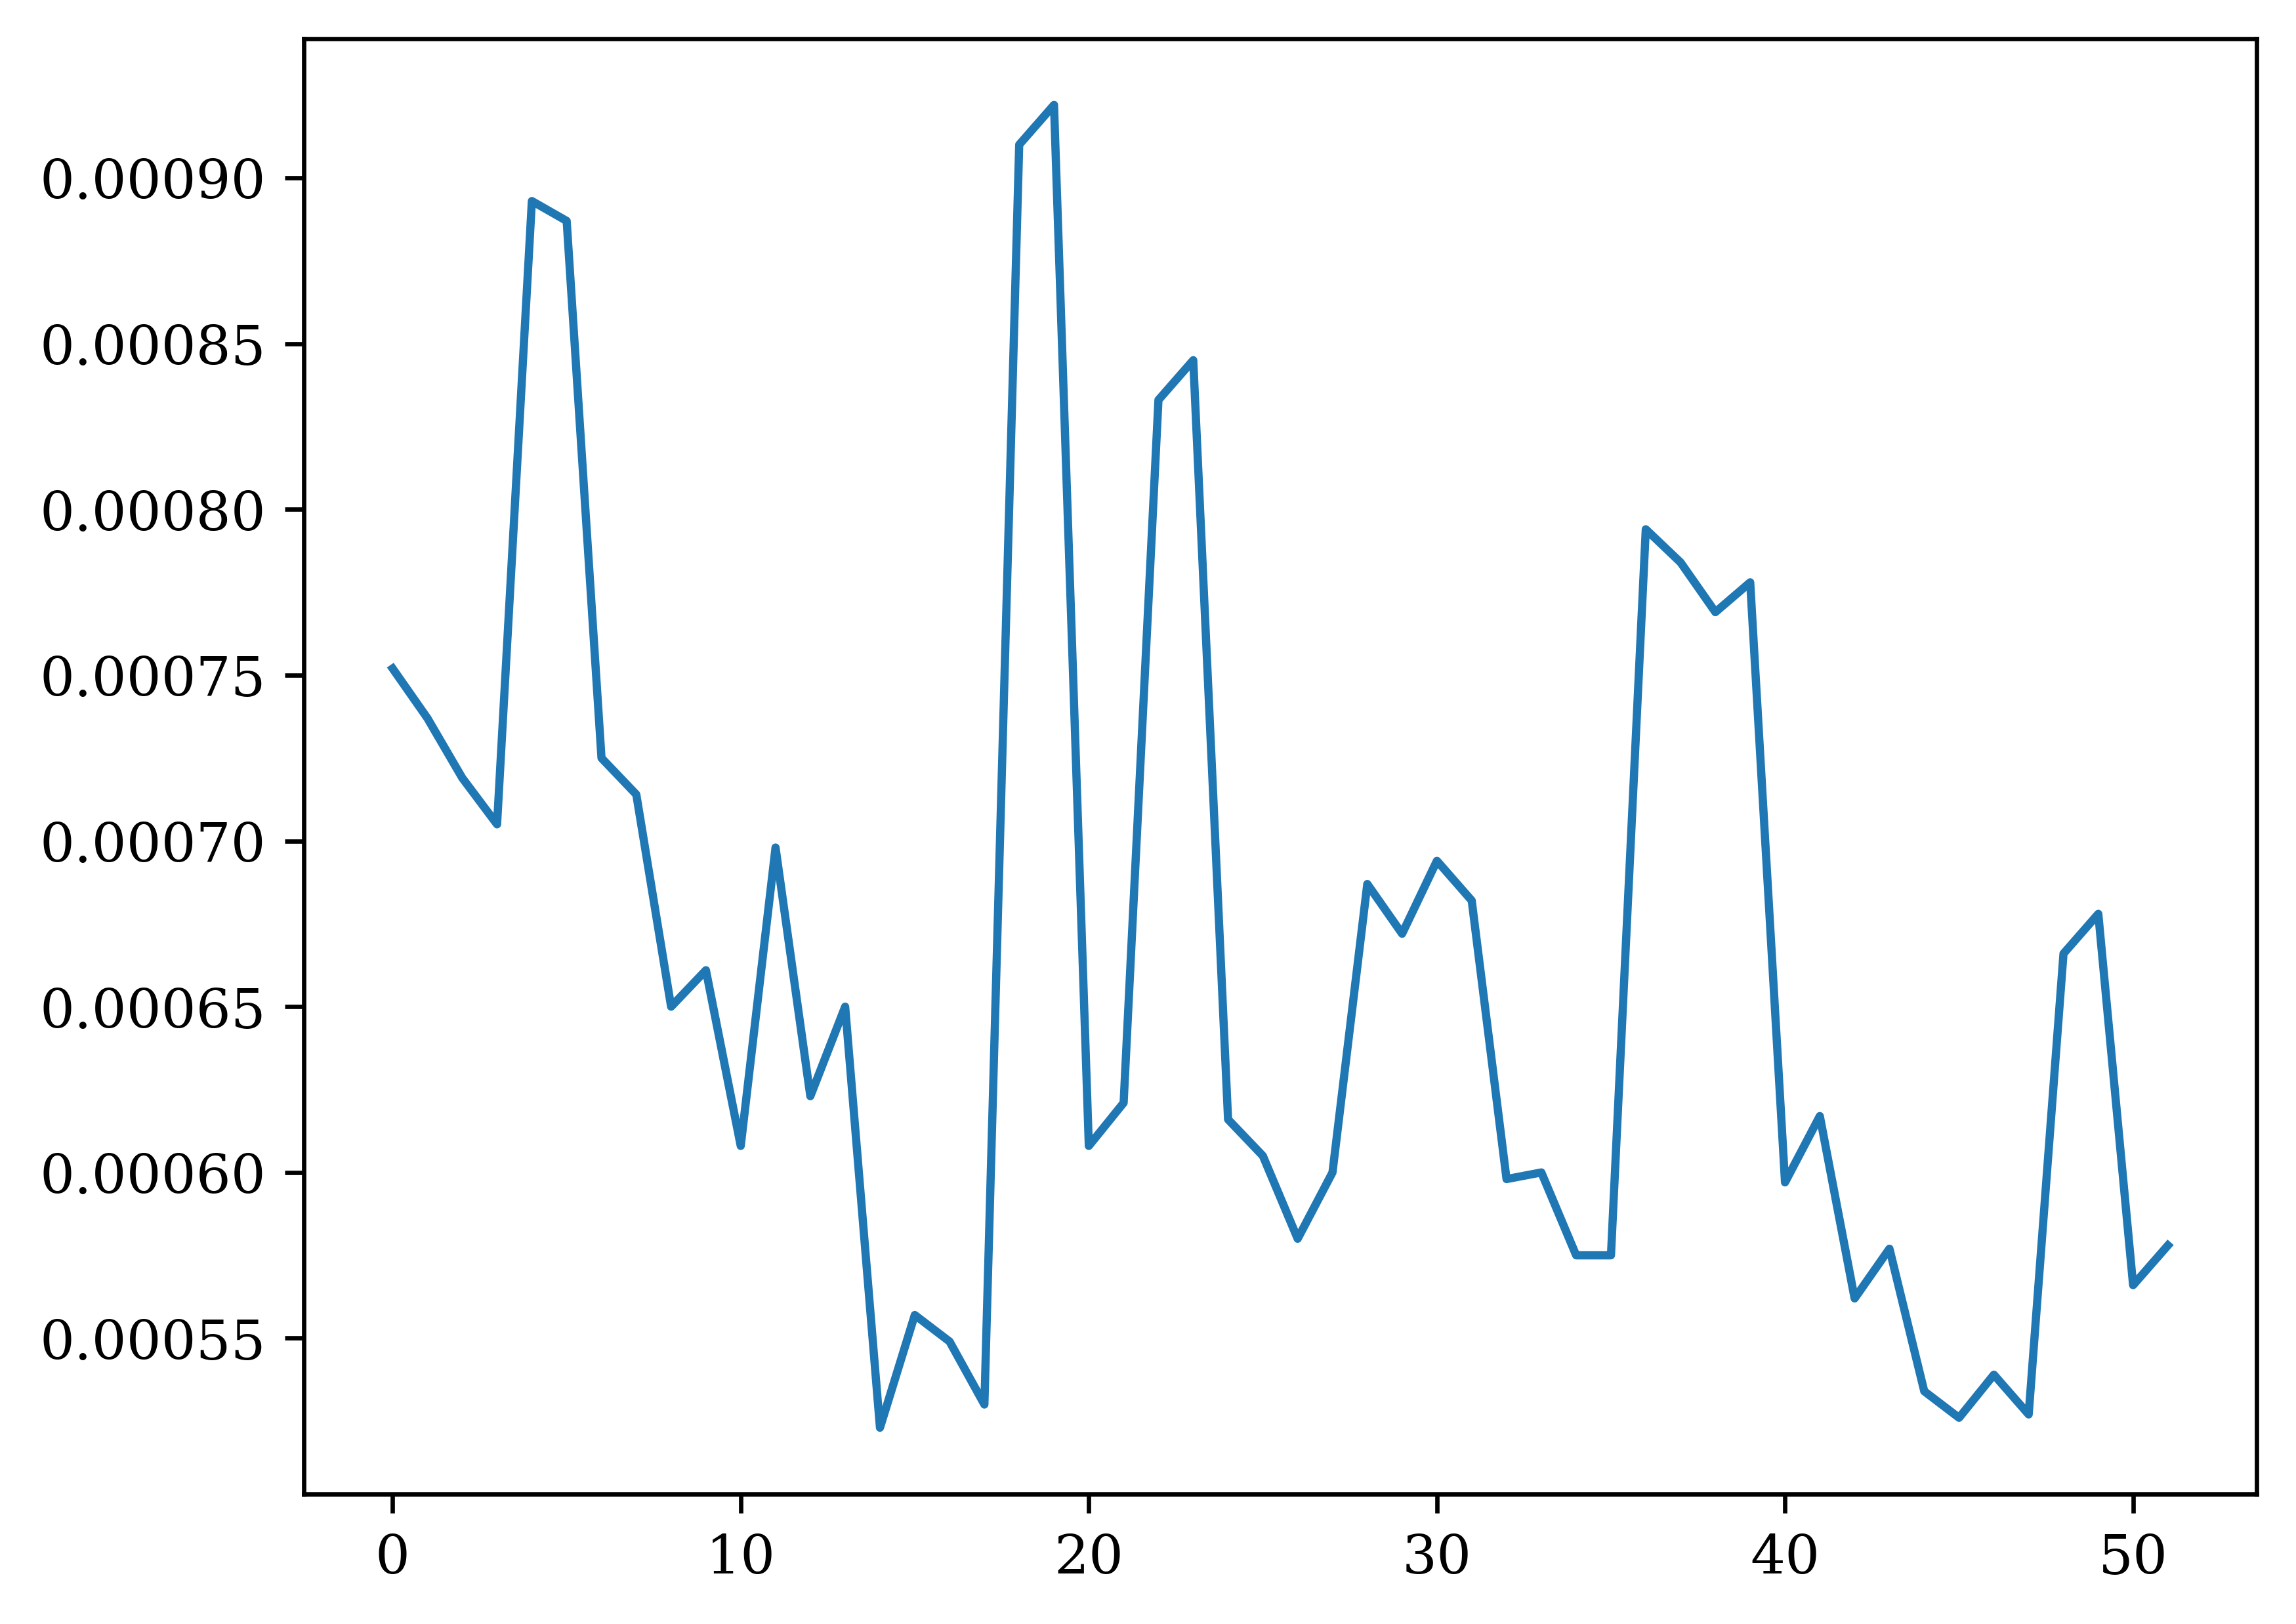

In [18]:
plt.plot(sorted_depth_df['mse'].to_numpy())

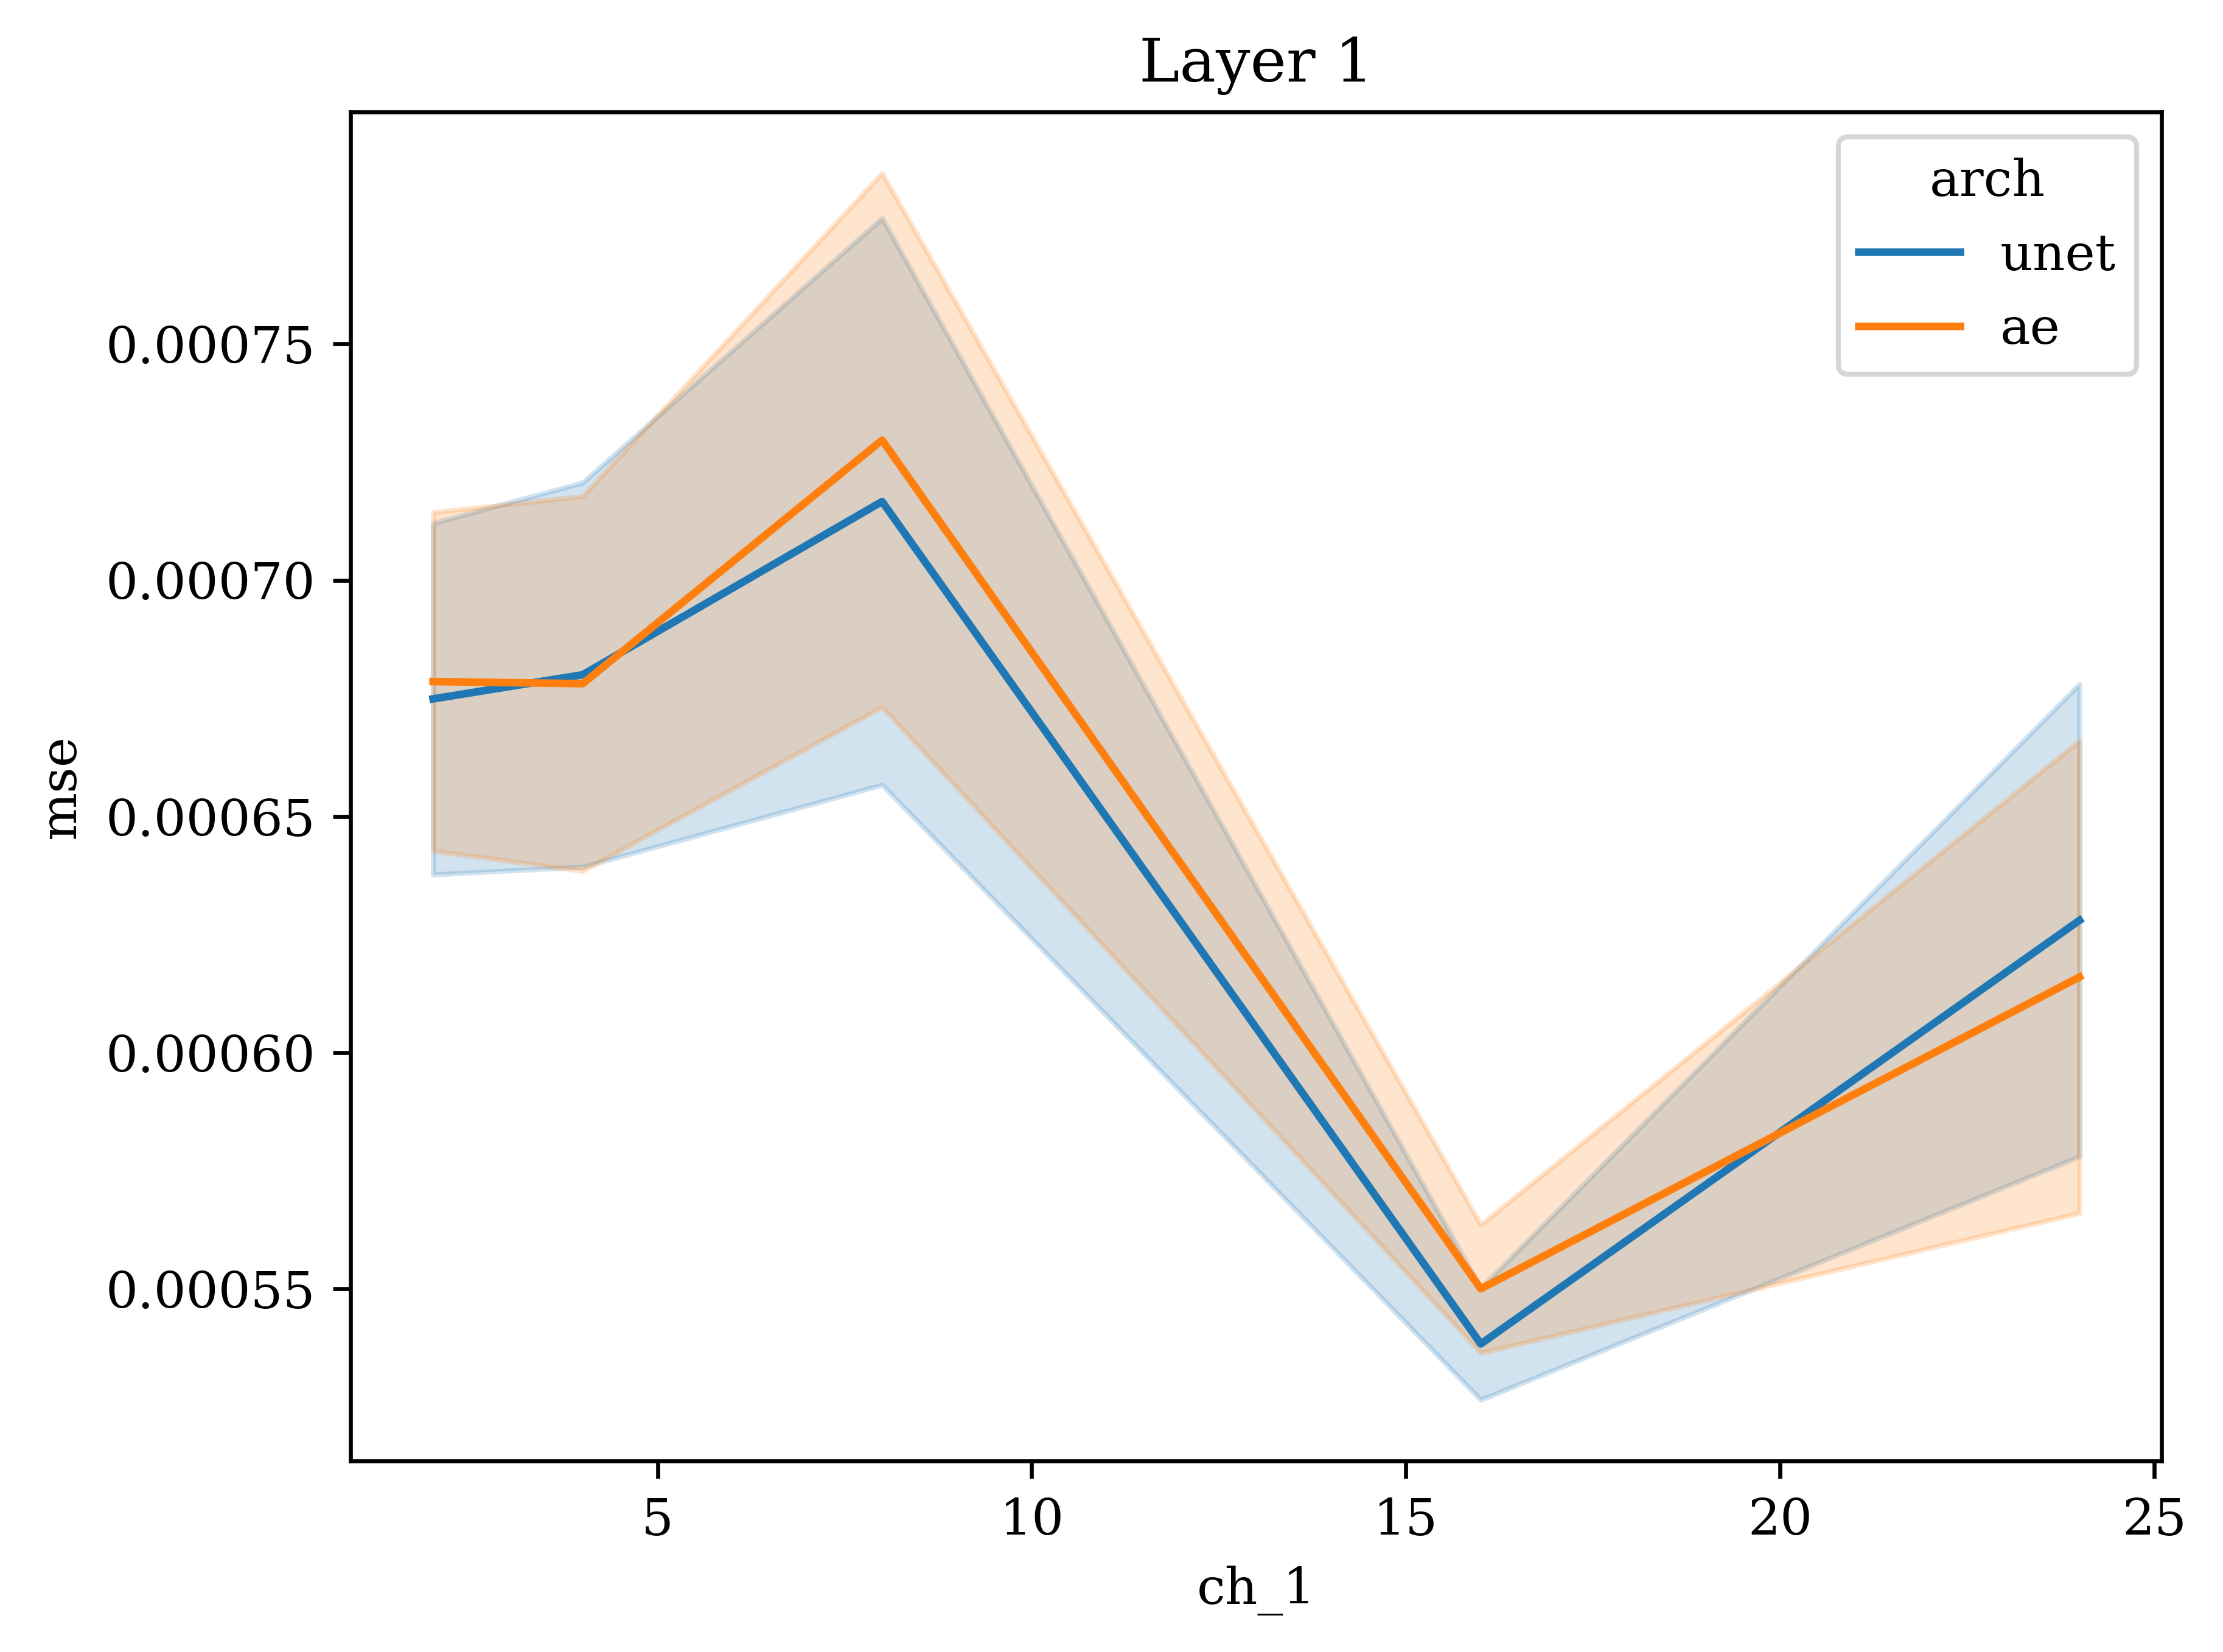

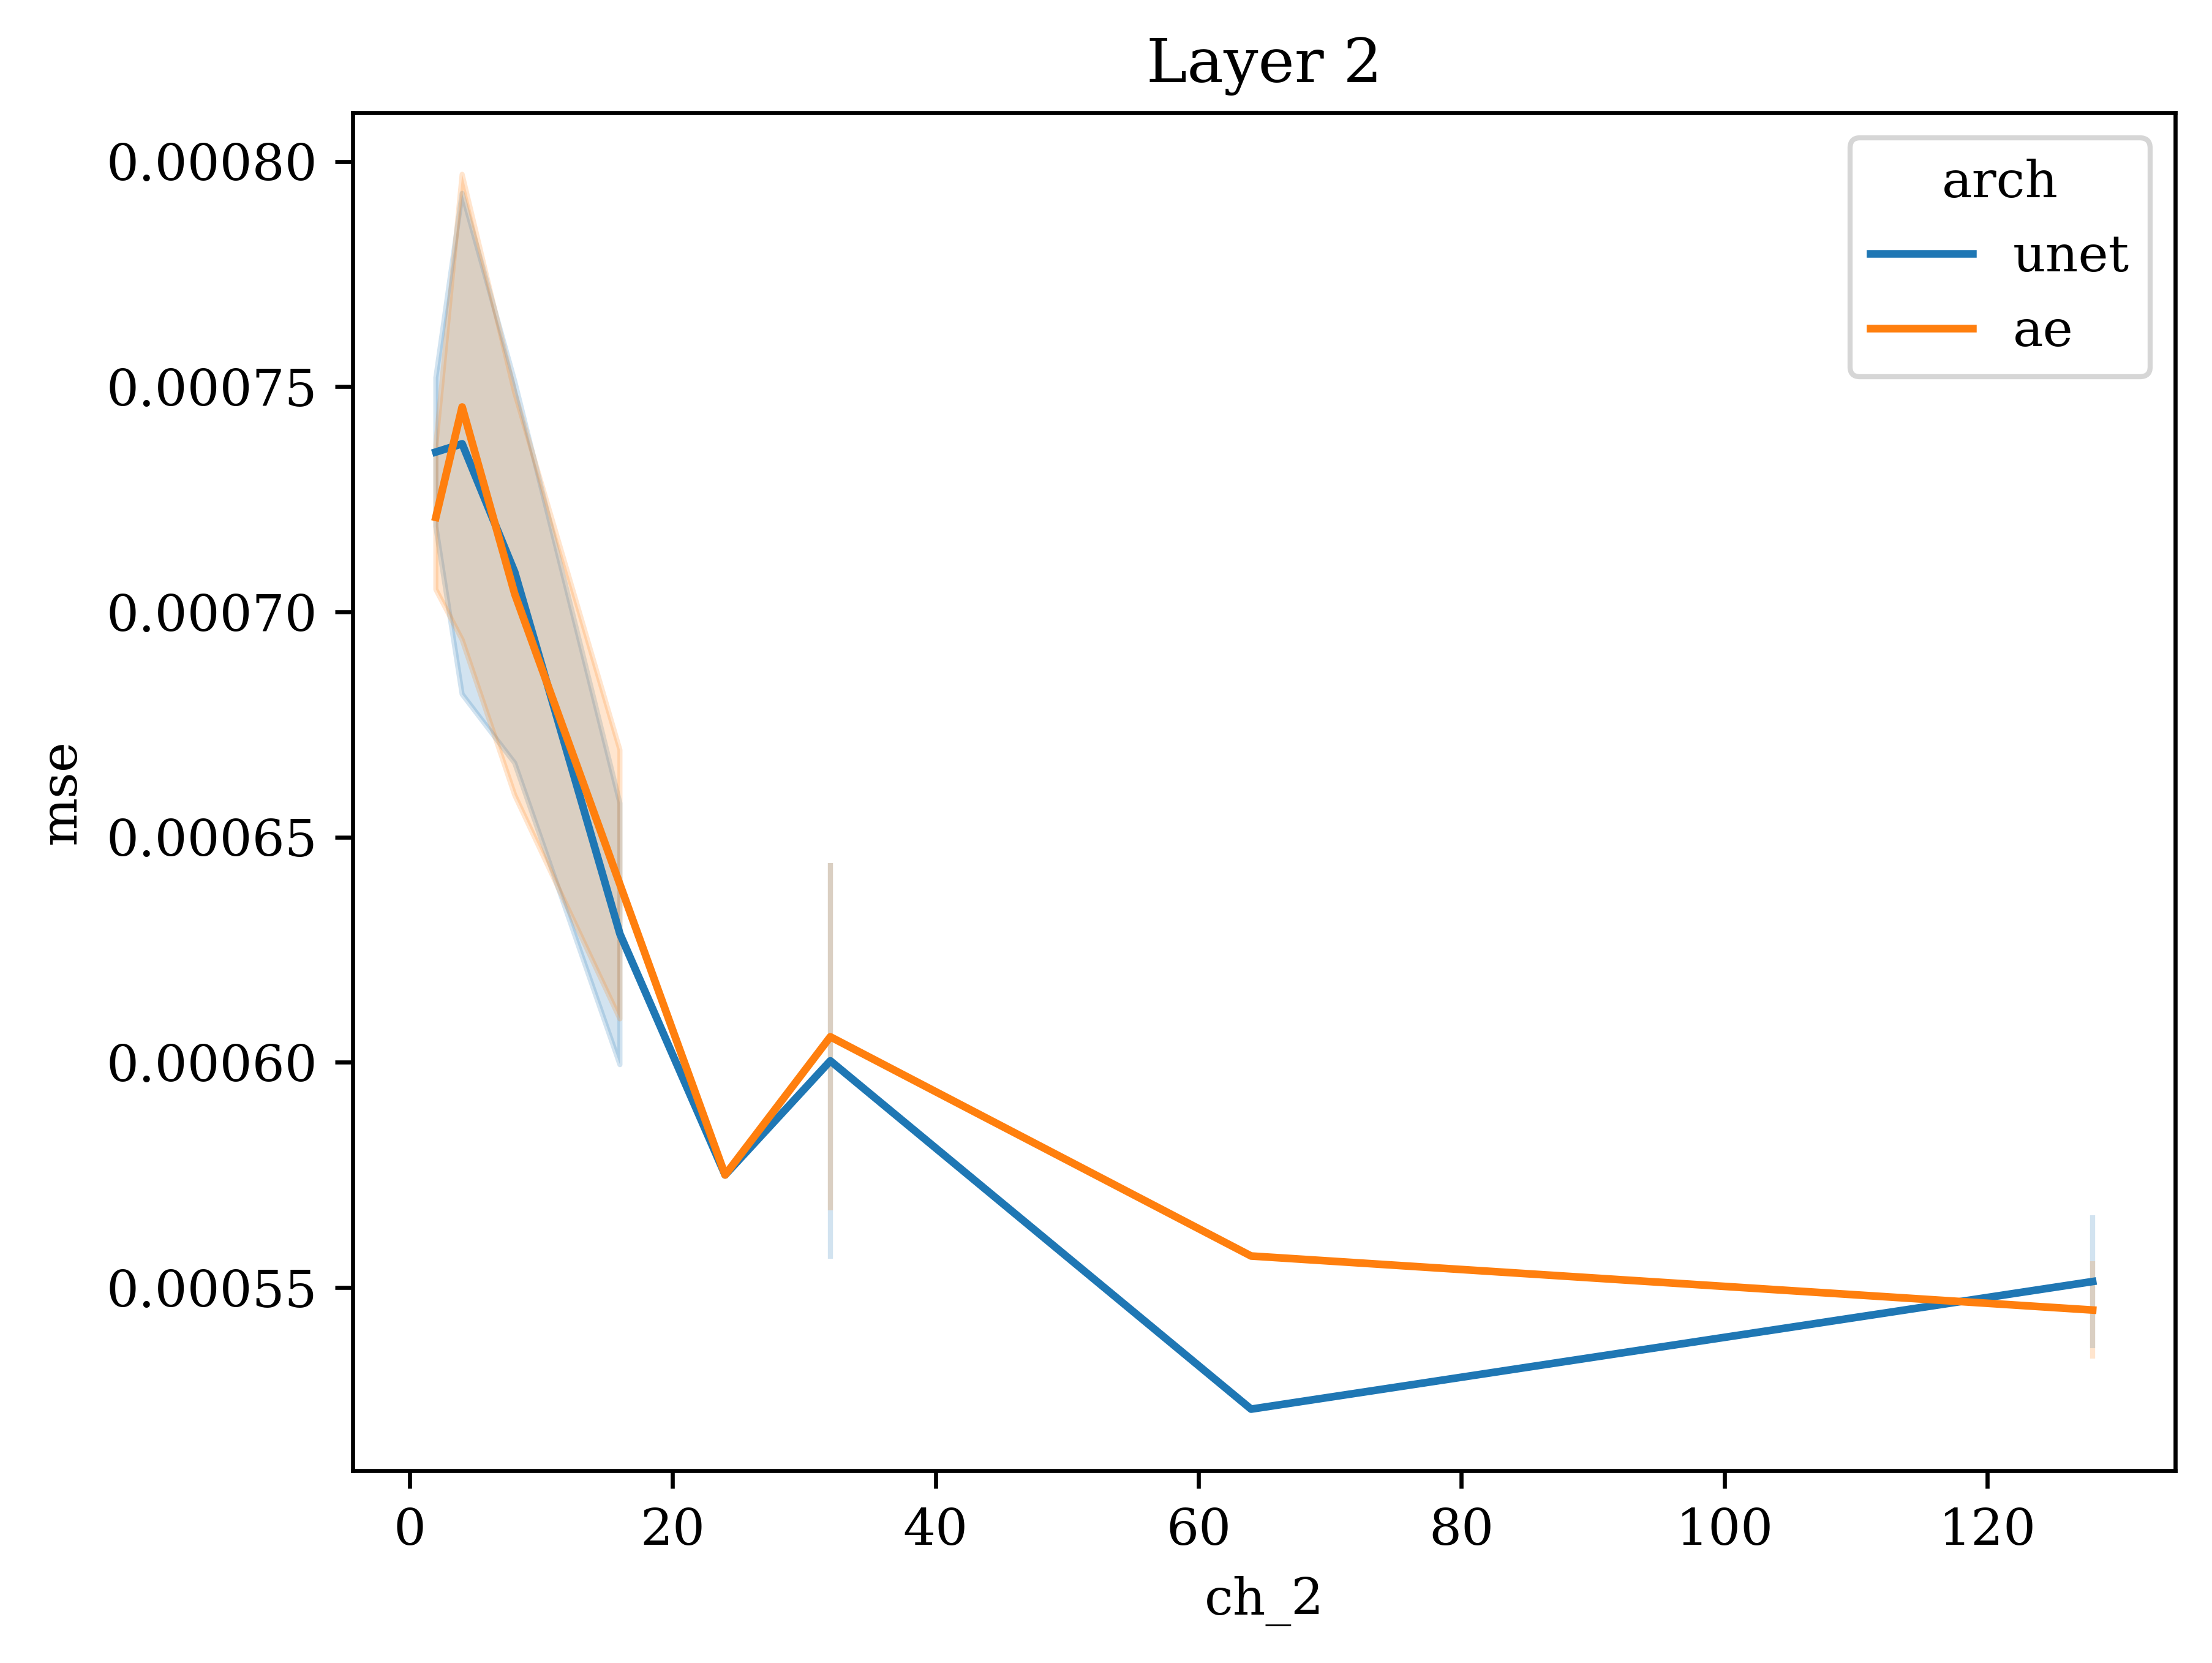

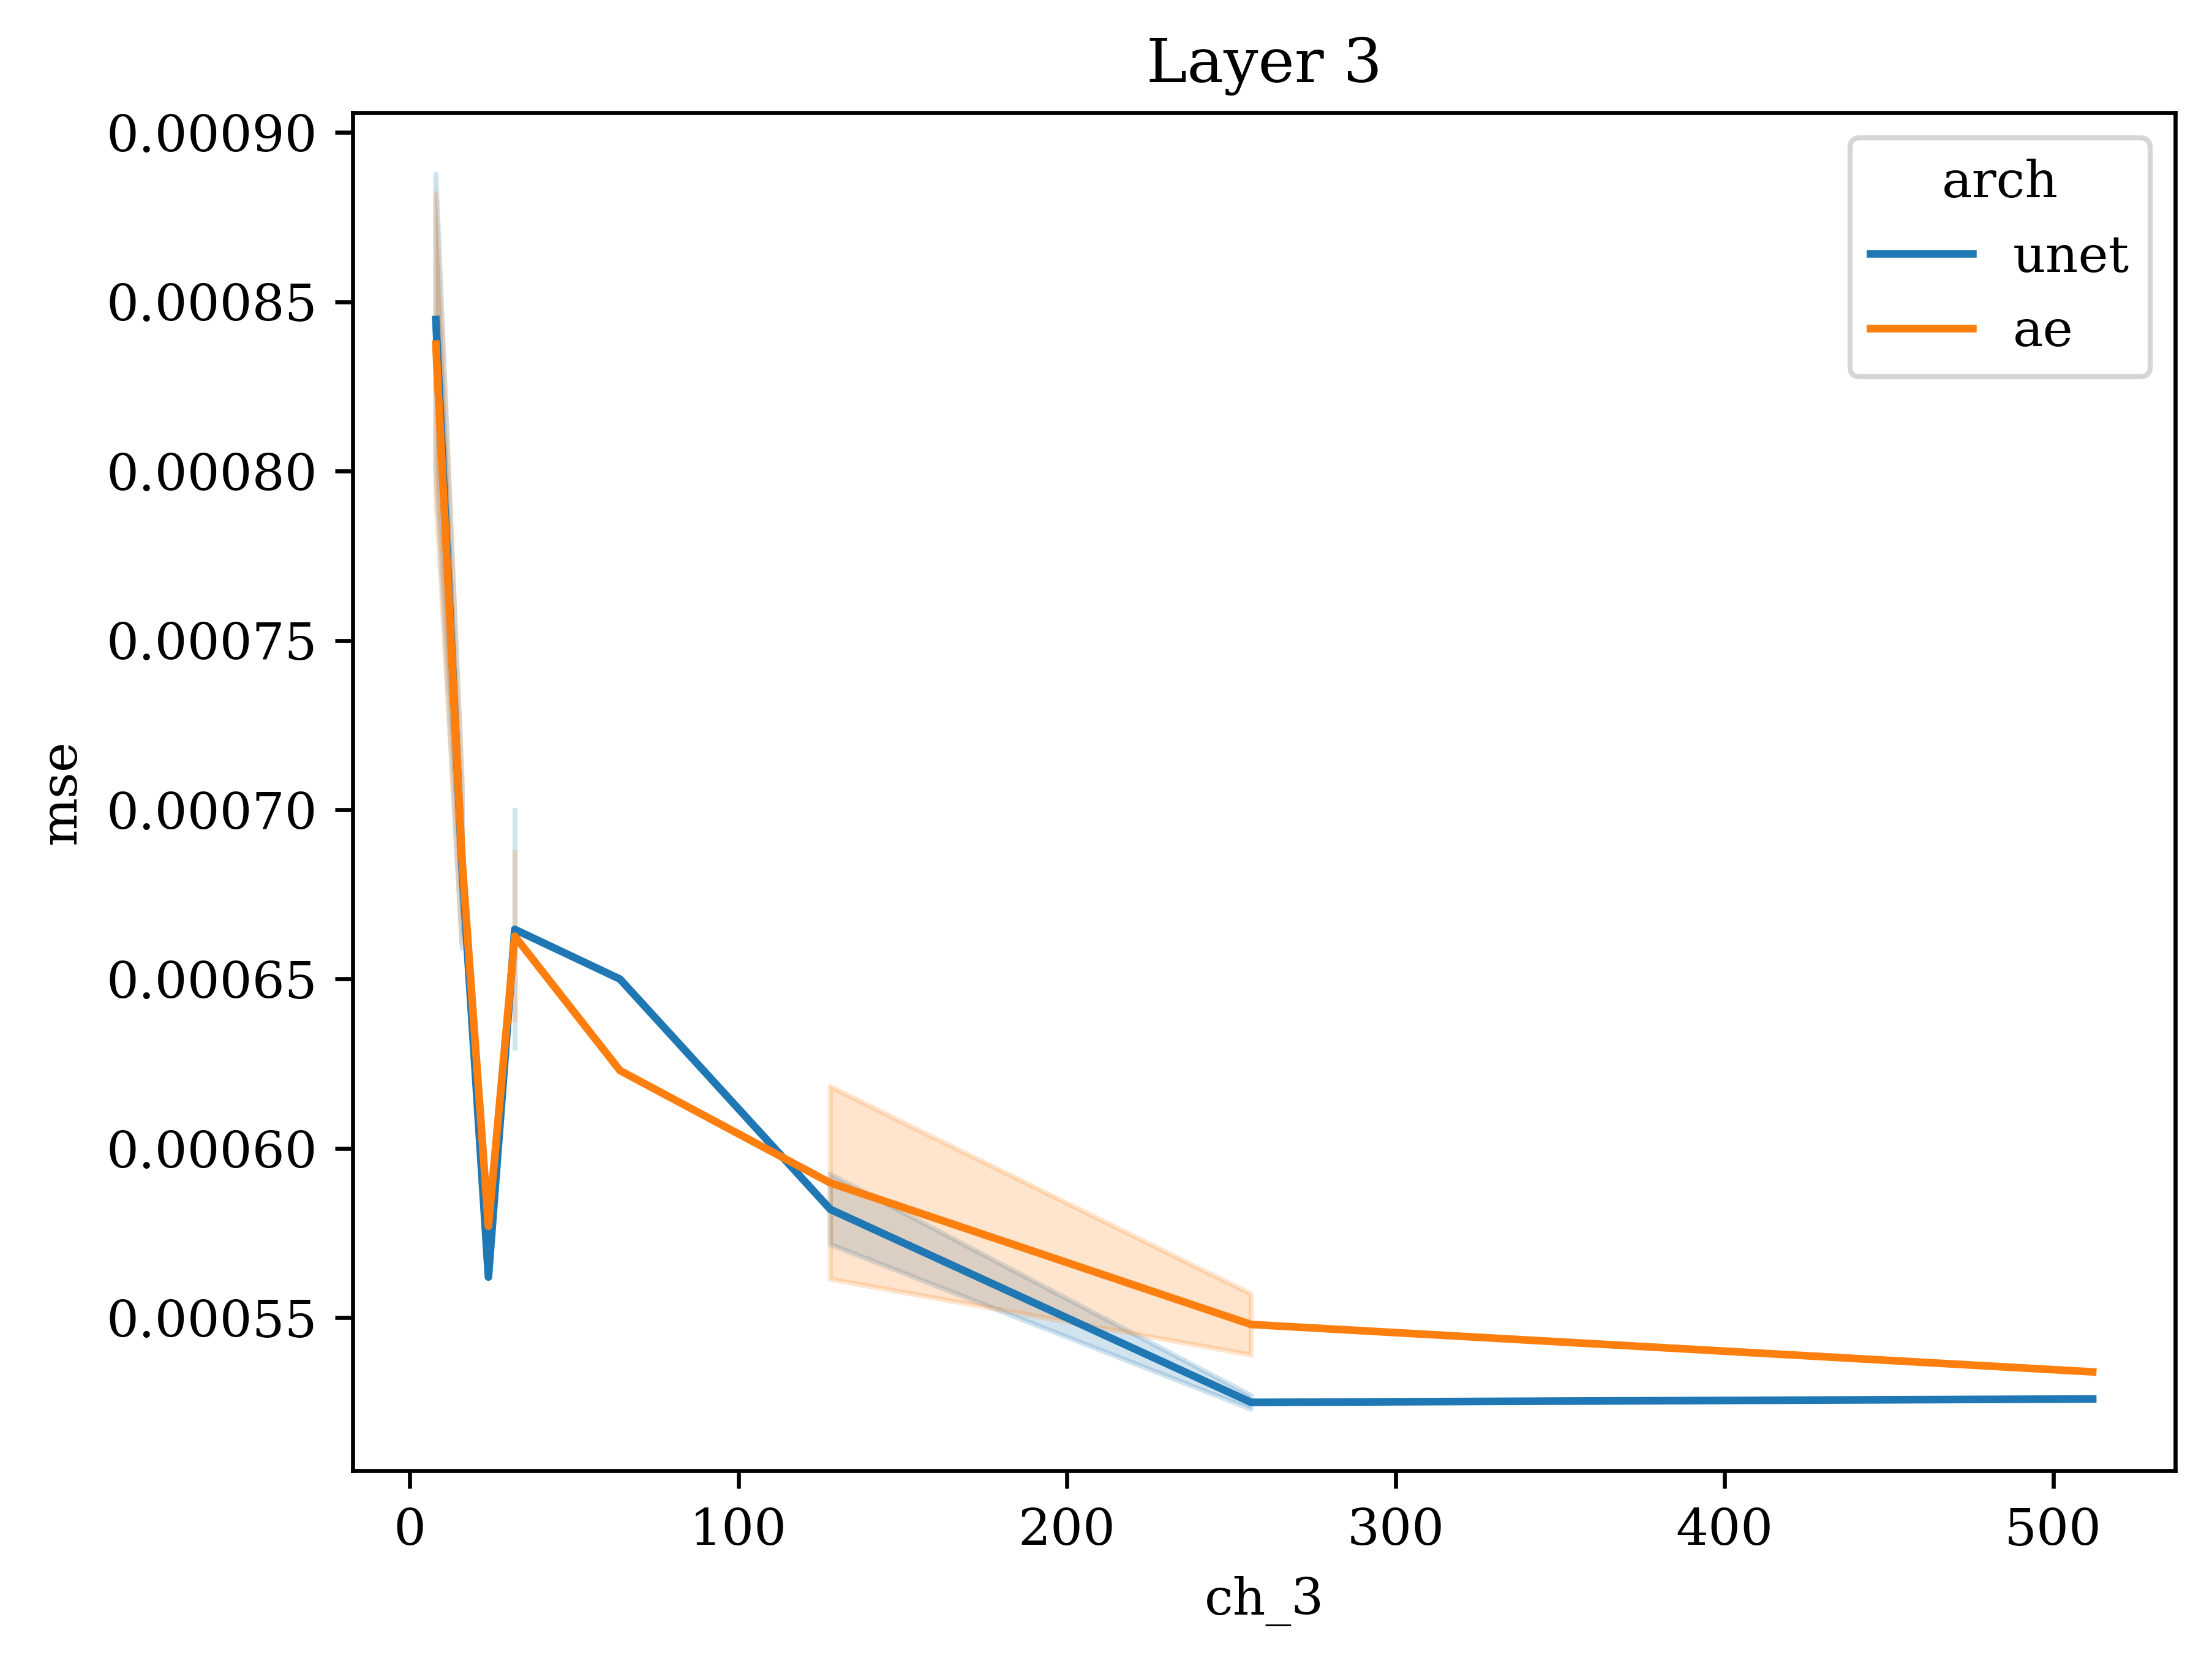

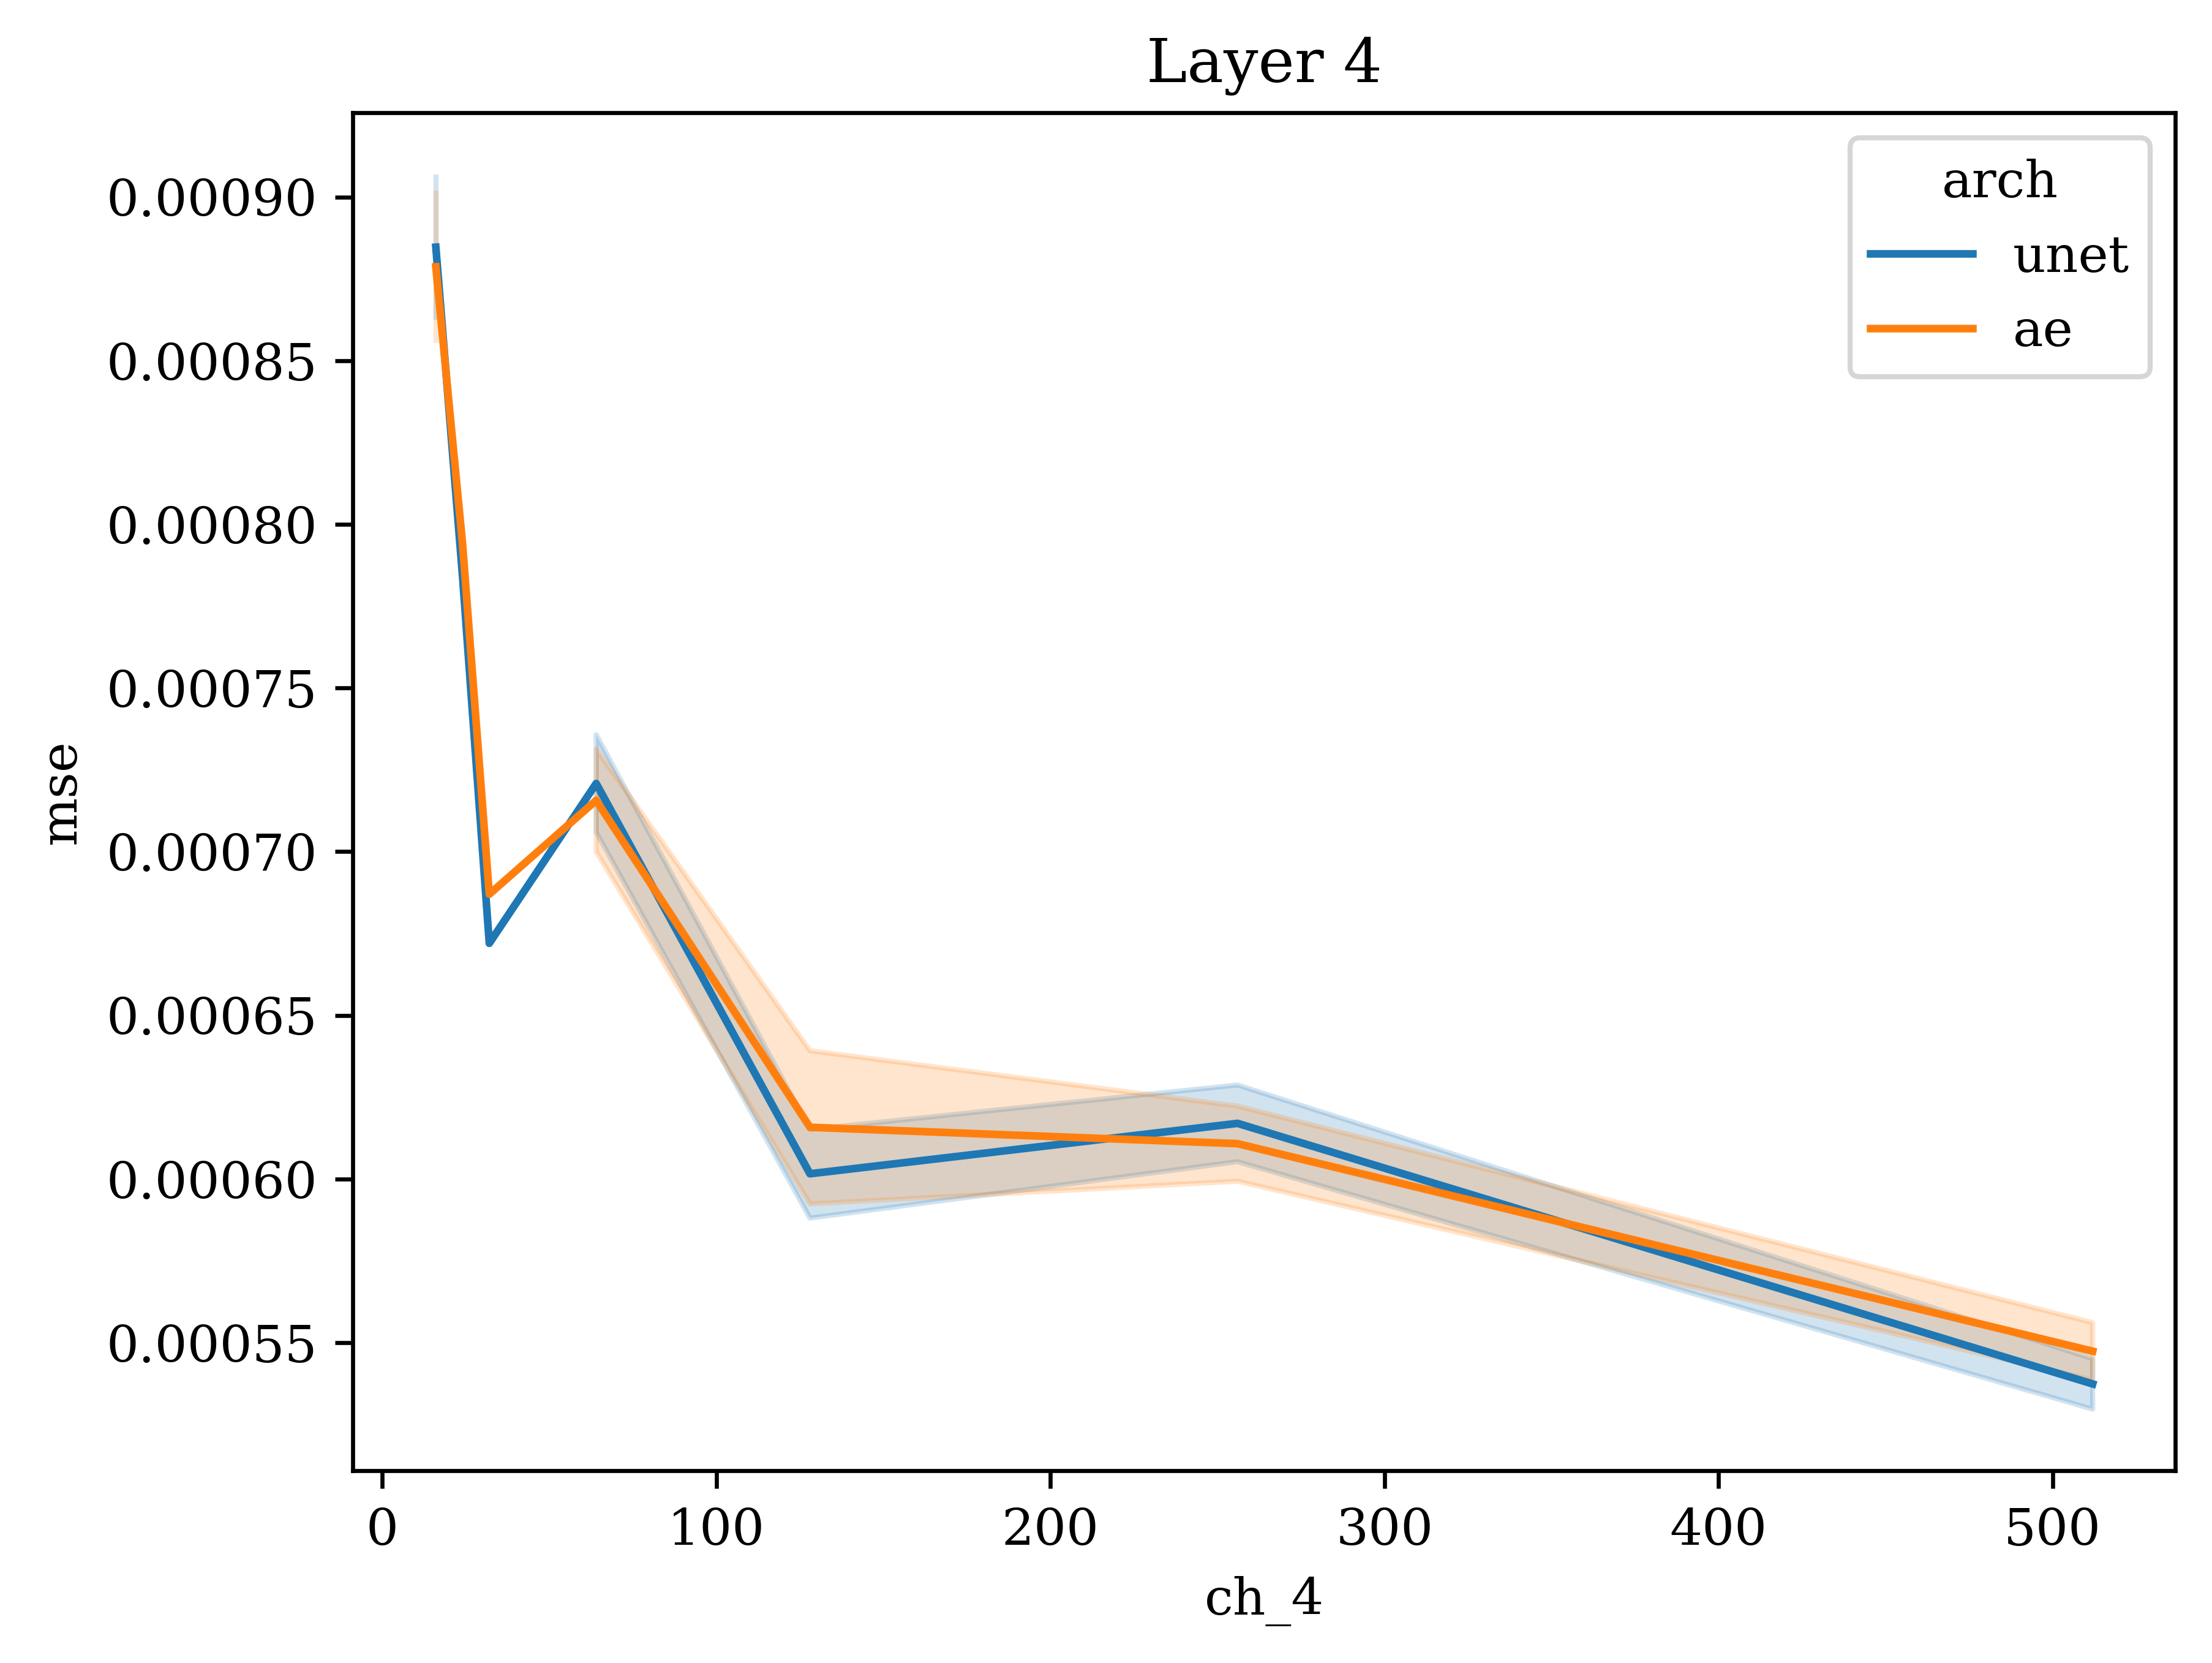

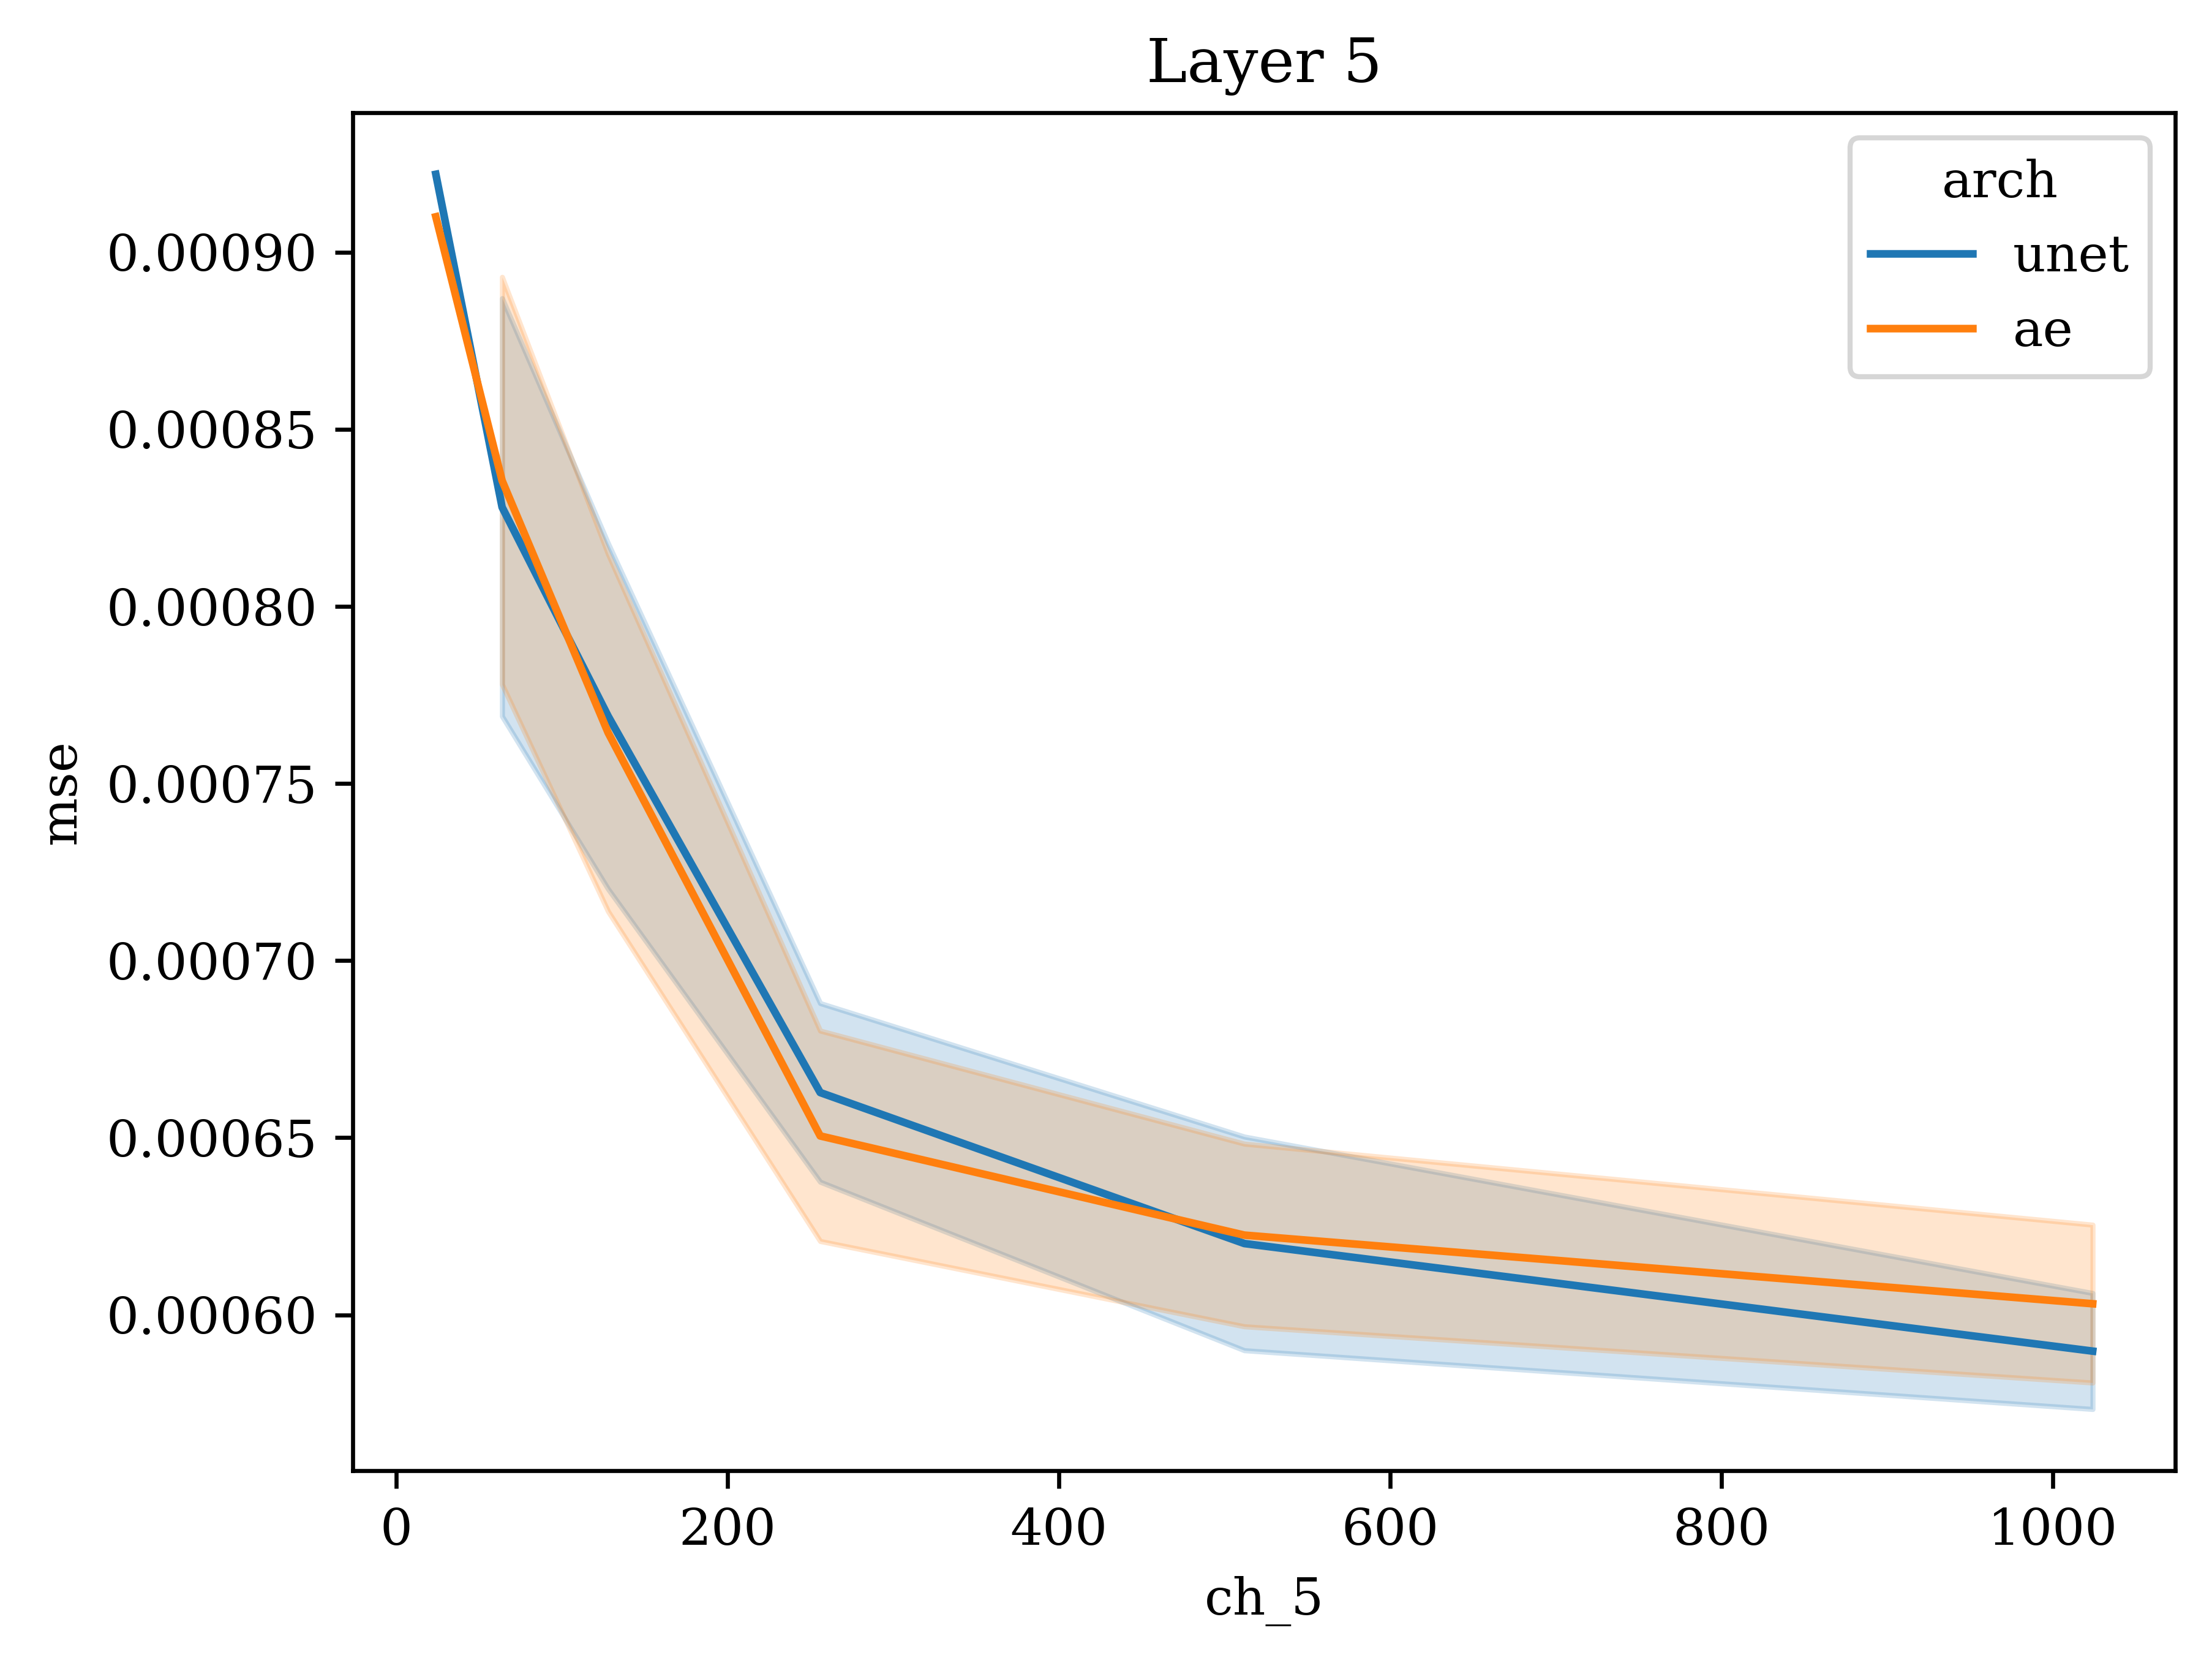

In [19]:
for i in range(1, 6):
    plt.figure()
    ax = sns.lineplot(data=sorted_depth_df, x=f'ch_{i}', y='mse', errorbar='se', hue='arch')
    ax.set_title(f'Layer {i}')

In [20]:
from itertools import combinations_with_replacement
from toolz import compose

In [21]:
ch = [2**x for x in range(2, 11)]
# already ordered and unique
combos = list(combinations_with_replacement(sorted(ch), 5))